In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
sys.path.append('/Users/ramtinyazdanian/PycharmProjects/job_skill_trend_analysis/')
from utilities.common_utils import *
from utilities.analysis_utils import *
from utilities.pandas_utils import *
from utilities.survey_response_utils import *
from utilities.classifier_utils import *
from utilities.constants import *
from utilities.params import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy.stats import shapiro, anderson, probplot
from scipy import stats
from itertools import chain

# Loading data

## Ad data

In [2]:
# Just basic loading stuff.
root_data_path = '/Users/ramtinyazdanian/Downloads/jobtech/'
all_filenames = os.listdir(root_data_path)
all_dataframes = [pd.read_csv(os.path.join(root_data_path,filename)) 
                  for filename in all_filenames if filename[-3:] == 'csv' and filename[0] != '~']
df_all = pd.concat(all_dataframes)
df_all_useful_cols = df_all[['companyName', 'industryId', 'datePosted', 'skills']].rename(columns={
    'companyName': 'Company', 'industryId': 'Industry', 'datePosted': 'Date', 'skills': 'Skill List'
})

df_all_useful_cols['Skill List'] = df_all_useful_cols['Skill List'].apply(eval)
df_all_useful_cols['Date'] = pd.to_datetime(df_all_useful_cols['Date'])
company_totals = divide_into_periods(df_all_useful_cols, ['Company'], result_col_name='Total')

df_all_useful_cols = explode(df_all_useful_cols, ['Skill List'])
df_all_useful_cols = df_all_useful_cols.loc[df_all_useful_cols['Skill List'].apply(lambda x: x != '')]

df_all_useful_cols['Skill'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skill'])
df_all_useful_cols['Skill Type'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skillTypeId'])
df_all_useful_cols = df_all_useful_cols.drop(columns='Skill List')

In [3]:
df_all_useful_cols.shape

(653618, 5)

In [4]:
# Filtering out the 2020 stuff and filtering out the non-IT skills.
absolute_start = np.datetime64('2017-01-01')
absolute_end = np.datetime64('2020-01-01')
it_skills = set(pd.read_csv('./it_skills.csv').Skill.values)
skills_df = divide_into_periods(df_all_useful_cols.loc[(df_all_useful_cols['Skill Type'] == 1) | 
                                                       (df_all_useful_cols['Skill Type'] == 2)], 
                                ['Company', 'Skill'], 
                                absolute_start, absolute_end, result_col_name='Job Postings Raw')
skills_df = pd.merge(skills_df, company_totals, on = ['Company', 'Date'])
skills_df['Job Postings'] = skills_df['Job Postings Raw'] / skills_df['Total']
skills_df = skills_df.loc[skills_df.Skill.apply(lambda x: x in it_skills)]

In [5]:
skills_df.sort_values('Date').head(10)

,Company,Skill,Date,Job Postings Raw,Total,Job Postings
124152,M1 Limited,python,2017-01-01,2,22,0.090909
100834,IHIS - Integrated Health Information Systems P...,ssl/tls,2017-01-01,1,15,0.066667
100833,IHIS - Integrated Health Information Systems P...,sql,2017-01-01,1,15,0.066667
15900,Agilysys Singapore Pte Ltd,system integration,2017-01-01,1,2,0.500000
15899,Agilysys Singapore Pte Ltd,sql,2017-01-01,1,2,0.500000
15895,Agilysys Singapore Pte Ltd,pos system,2017-01-01,1,2,0.500000
15894,Agilysys Singapore Pte Ltd,multi-task,2017-01-01,1,2,0.500000
15893,Agilysys Singapore Pte Ltd,microsoft office suite,2017-01-01,1,2,0.500000
15892,Agilysys Singapore Pte Ltd,microsoft office (powerpoint),2017-01-01,1,2,0.500000
15891,Agilysys Singapore Pte Ltd,microsoft office (excel),2017-01-01,1,2,0.500000


In [6]:
len(skills_df.Skill.unique().tolist())

987

In [7]:
len(skills_df.Company.unique().tolist())

2264

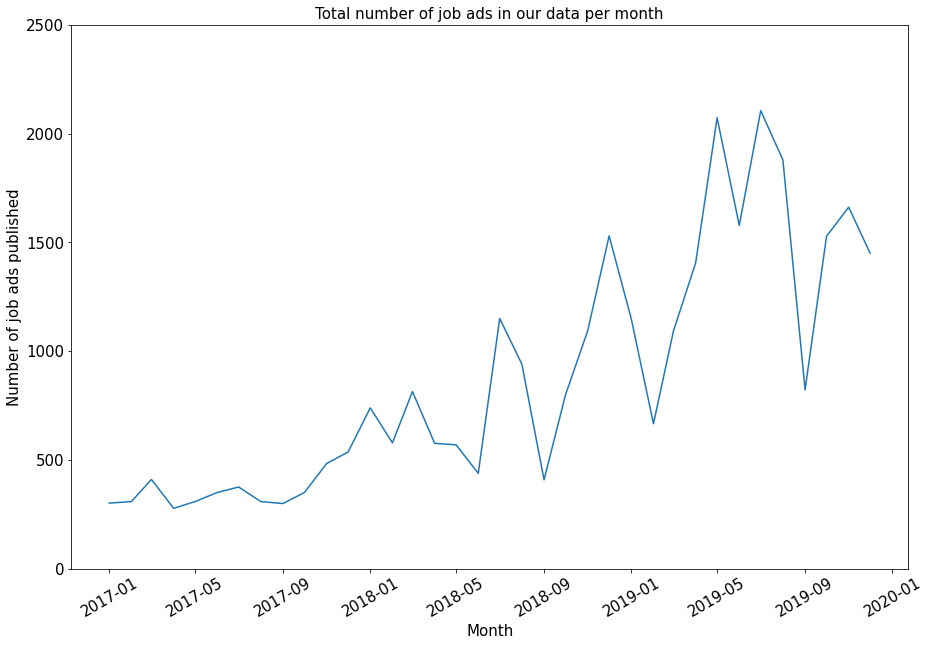

In [8]:
plt.figure(figsize=(15,10))
plt.plot(skills_df[['Company', 'Date', 'Total']].drop_duplicates().groupby('Date').sum())
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Number of job ads published', fontsize=15)
plt.ylim([0,2500])
plt.xlabel('Month', fontsize=15)
plt.title('Total number of job ads in our data per month', fontsize=15)
plt.show()

# Creating ground truth out of ad data

In [9]:
# Aggregating each skill's data by month
monthly_skill_data = skills_df[['Skill', 'Date', 'Job Postings Raw']].groupby(['Skill', 'Date']).sum().\
                reset_index().rename(columns={'Job Postings Raw': 'Count', 'Skill': 'TagName'})
monthly_skill_data['Date'] = monthly_skill_data['Date'].astype(str)
monthly_skill_data.head(10)

,TagName,Date,Count
0,.net,2017-01-01,19
1,.net,2017-02-01,16
2,.net,2017-03-01,34
3,.net,2017-04-01,24
4,.net,2017-05-01,26
5,.net,2017-06-01,23
6,.net,2017-07-01,23
7,.net,2017-08-01,20
8,.net,2017-09-01,25
9,.net,2017-10-01,19


In [10]:
# For plotting, the log-monthly data
log_monthly_skill_data = skills_df[['Skill', 'Company', 'Date', 'Job Postings Raw']].\
            assign(log_val=skills_df['Job Postings Raw'].apply(np.log))[['Skill', 'Date', 'log_val']].\
                groupby(['Skill', 'Date']).sum().\
                    reset_index().rename(columns={'log_val': 'Logpop', 'Skill': 'TagName'})
log_monthly_skill_data['Date'] = log_monthly_skill_data['Date'].astype(str)
log_monthly_skill_data.head(10)

,TagName,Date,Logpop
0,.net,2017-01-01,3.178054
1,.net,2017-02-01,1.945910
2,.net,2017-03-01,5.337538
3,.net,2017-04-01,4.852030
4,.net,2017-05-01,5.375278
5,.net,2017-06-01,3.688879
6,.net,2017-07-01,5.545177
7,.net,2017-08-01,4.025352
8,.net,2017-09-01,3.871201
9,.net,2017-10-01,4.248495


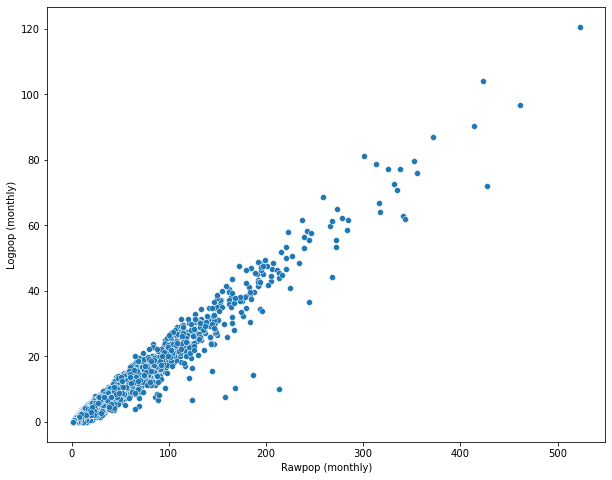

In [11]:
plt.subplots(1,1,figsize=(10,8))
sns.scatterplot(data=pd.merge(monthly_skill_data, log_monthly_skill_data, on=['TagName', 'Date']), 
                x='Count', y='Logpop')
plt.xlabel('Rawpop (monthly)')
plt.ylabel('Logpop (monthly)')
plt.show()

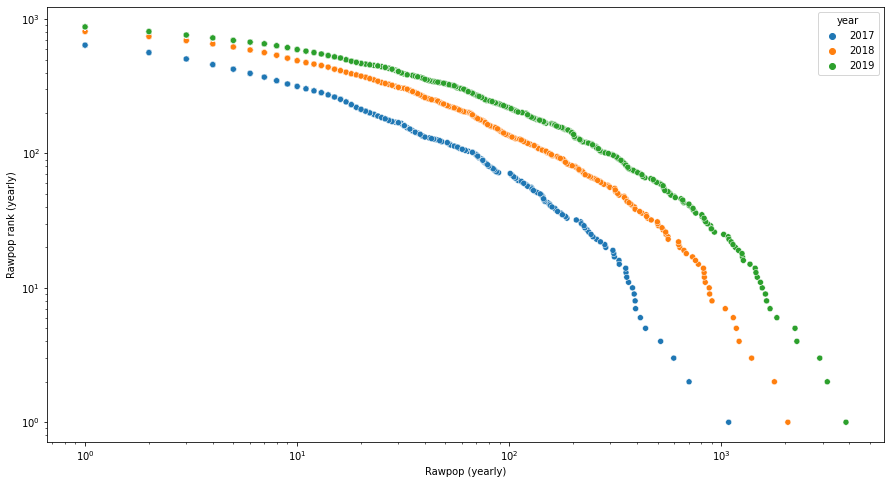

In [12]:
plt.subplots(1,1,figsize=(15,8))
aggregated_by_year_rawpop = \
        monthly_skill_data.assign(year=monthly_skill_data.Date.apply(lambda x: x.split('-')[0])).\
                                  groupby(['year', 'TagName']).sum().reset_index()
rawpop_ranked = aggregated_by_year_rawpop.assign(Ranking=
                    aggregated_by_year_rawpop[['year', 'TagName', 'Count']].\
                         groupby('year').rank(ascending=False).Count)
sns.scatterplot(data=rawpop_ranked, 
                x='Count', y='Ranking', hue='year')
plt.xlabel('Rawpop (yearly)')
plt.ylabel('Rawpop rank (yearly)')
plt.xscale('log')
plt.yscale('log')

## Continuous ground truth

In [13]:
def get_top_k_per_period(tag_counts_monthly, k, n_periods=4):
    result = tag_counts_monthly.assign(year=tag_counts_monthly.Date.\
                        apply(lambda x: x.split('-')[0])).assign(period=tag_counts_monthly.Date.\
                        apply(lambda x: str((int(x.split('-')[1])-1) // (12//n_periods)))).\
                        groupby(['year', 'period', 'TagName']).sum().reset_index().\
                        sort_values(by=['year', 'period', 'Count'],
                            ascending=[True, True, False])[['year', 'period', 'TagName', 'Count']]
    if k == -1:
        return result
    return result.groupby(['year', 'period']).head(k).reset_index().drop('index', axis=1)

def get_skill_af_icf_scores(full_skill_df, tag_counts_monthly, n_periods=4, with_icf=True, with_log=True):
    """
    Computes the period-wise AF-ICF score for each skill. AF-ICF stands for Ad Frequency - Inverse Company Frequency. 
    The use of ICF can be disabled, and so can the use of the logarithm for the AF. The recommended settings are 
    with_icf=False and with_log=False, as this means that af-icf == ad count, which is a sensible measure already.
    """
    af_df = get_top_k_per_period(tag_counts_monthly, k=-1, n_periods=n_periods)
    base_icf_df = full_skill_df[['Company', 'Skill', 'Date']].assign(Count=1).\
                    assign(year=full_skill_df.Date.\
                        apply(lambda x: str(x).split('-')[0])).assign(period=full_skill_df.Date.\
                            apply(lambda x: str((int(str(x).split('-')[1])-1) // (12//n_periods)))).\
                                rename(columns={'Skill': 'TagName'})
    base_icf_df = base_icf_df.drop('Date', axis=1).drop_duplicates()
    total_company_counts = base_icf_df[['year', 'period', 'Company', 'Count']].drop_duplicates().\
                                groupby(['year', 'period']).sum().reset_index().rename(columns={'Count': 'Companies'})
    icf_df = base_icf_df[['TagName', 'year', 'period', 'Count']].\
                                groupby(['TagName', 'year', 'period']).sum().reset_index()
    joined_df = pd.merge(af_df, icf_df, on=['TagName', 'year', 'period'], suffixes=('_af', '_icf'), how='outer')
    joined_df['Count_af'] = joined_df['Count_af'].apply(lambda x: x if not pd.isnull(x) else 0)
    joined_df['Count_icf'] = joined_df['Count_icf'].apply(lambda x: x if not pd.isnull(x) else 0)
    joined_df = pd.merge(joined_df, total_company_counts, on=['year', 'period'])
    if with_log:
        joined_df['af'] = joined_df['Count_af'].apply(lambda x: np.log(1+x))
    else:
        joined_df['af'] = joined_df['Count_af']
    if with_icf:
        joined_df['icf'] = joined_df.apply(lambda x: np.log(x['Companies'] / (x['Count_icf'] + 1)), axis=1)
        joined_df['score'] = joined_df.apply(lambda x: x['af']*x['icf'], axis=1)
    else:
        joined_df['score'] = joined_df['af']
    return joined_df.sort_values(by=['year', 'period', 'score'], 
                            ascending=[True, True, False])
    

In [14]:
af_icf_scores = get_skill_af_icf_scores(skills_df, monthly_skill_data, n_periods=2, with_icf=False, with_log=False)

In [15]:
def get_separate_emerging_skills(aficf, q_old=0.8, q_diff=0.65):
    """
    Computes the emerging skills based on two thresholds on te AF-ICF score: the old score upper bound (q_old)
    and the difference lower bound (q_diff). Does it separately for each year-period pair, and does not aggregate 
    for each year. The bounds are quantiles, between 0 and 1.
    """
    af_icf_per_year = aficf[['year', 'period', 'TagName', 'score']].groupby(['year', 'period', 'TagName']).\
                                                                sum().reset_index()
    af_icf_per_year = pd.merge(af_icf_per_year, 
                       af_icf_per_year.assign(year=af_icf_per_year.year.apply(lambda x: str(int(x)+1))), 
                               on=['year', 'period', 'TagName'], suffixes=('_new', '_old'), how='outer')
    af_icf_per_year = af_icf_per_year.loc[af_icf_per_year.year != af_icf_per_year.year.min()]
    af_icf_per_year['score_old'] = af_icf_per_year['score_old'].apply(lambda x: x if not pd.isnull(x) else 0)
    af_icf_per_year = af_icf_per_year.dropna(axis=0)
    af_icf_per_year['score_diff'] = af_icf_per_year.apply(lambda x: x['score_new']-x['score_old'], axis=1)
    # af_icf_per_year['score_diff'] = af_icf_per_year.apply(lambda x: 
    #             x['score_diff']/(2+np.log(1+x['score_old'])), axis=1)
    old_score_quantiles = {year: {period: af_icf_per_year.loc[(af_icf_per_year.year==year) & 
                                                              (af_icf_per_year.period==period)].\
                                                                      score_old.quantile(q_old)
                                 for period in af_icf_per_year.period.unique()} 
                                           for year in af_icf_per_year.year.unique()}
    print(old_score_quantiles)
    diff_quantiles = {year: {period: 
                               af_icf_per_year.loc[(af_icf_per_year.year==year) & 
                                              (af_icf_per_year.period==period)].score_diff.quantile(q_diff) 
                                                       for period in af_icf_per_year.period.unique()}
                                                           for year in 
                                                                af_icf_per_year.year.unique()}
    print(diff_quantiles)
    af_icf_top_ranks = af_icf_per_year.loc[(af_icf_per_year.\
                              apply(lambda x: x['score_old'] <= old_score_quantiles[x['year']][x['period']], 
                                    axis=1)) & 
                                     (af_icf_per_year.\
                              apply(lambda x: x['score_diff'] >= diff_quantiles[x['year']][x['period']], 
                                    axis=1))].copy()
    af_icf_top_ranks = af_icf_top_ranks.sort_values(['year', 'period', 'score_diff'], ascending=[True, True, False])
    return af_icf_per_year, af_icf_top_ranks

def get_all_emerging_skills(aficf, q_old=0.8, q_diff=0.65):
    """
    Computes the emerging skills based on two thresholds on te AF-ICF score: the old score upper bound (q_old)
    and the difference lower bound (q_diff). Aggregates for the whole year. The bounds are quantiles, between 0 
    and 1.
    """
    af_icf_per_year = aficf[['year', 'TagName', 'score']].groupby(['year', 'TagName']).sum().reset_index()
    af_icf_per_year = pd.merge(af_icf_per_year, 
                       af_icf_per_year.assign(year=af_icf_per_year.year.apply(lambda x: str(int(x)+1))), 
                               on=['year', 'TagName'], suffixes=('_new', '_old'), how='outer')
    af_icf_per_year = af_icf_per_year.loc[af_icf_per_year.year != af_icf_per_year.year.min()]
    af_icf_per_year['score_old'] = af_icf_per_year['score_old'].apply(lambda x: x if not pd.isnull(x) else 0)
    af_icf_per_year['score_new'] = af_icf_per_year['score_new'].apply(lambda x: x if not pd.isnull(x) else 0)
#     af_icf_per_year = af_icf_per_year.dropna(axis=0)
    af_icf_per_year['score_diff'] = af_icf_per_year.apply(lambda x: x['score_new']-x['score_old'], axis=1)
    # af_icf_per_year['score_diff'] = af_icf_per_year.apply(lambda x: 
    #             x['score_diff']/(2+np.log(1+x['score_old'])), axis=1)
    old_score_quantiles = {year: af_icf_per_year.loc[af_icf_per_year.year==year].score_old.quantile(q_old) 
                           for year in af_icf_per_year.year.unique()}
    print(old_score_quantiles)
    diff_quantiles = {year: af_icf_per_year.loc[af_icf_per_year.year==year].score_diff.quantile(q_diff) for year in 
                af_icf_per_year.year.unique()}
    print(diff_quantiles)
    af_icf_top_ranks = af_icf_per_year.loc[(af_icf_per_year.\
                              apply(lambda x: x['score_old'] <= old_score_quantiles[x['year']], axis=1)) & 
                                     (af_icf_per_year.\
                              apply(lambda x: x['score_diff'] >= diff_quantiles[x['year']], axis=1))].copy()
    af_icf_top_ranks = af_icf_top_ranks.sort_values(['year', 'score_diff'], ascending=[True, False])
    return af_icf_per_year, af_icf_top_ranks, old_score_quantiles, diff_quantiles

In [16]:
# The data we'll use for our ground truth
af_icf_per_year, af_icf_top_ranks, old_score_quantiles, diff_quantiles = \
                get_all_emerging_skills(af_icf_scores, 0.8, 0.65)
af_icf_periods, af_icf_top_periods = get_separate_emerging_skills(af_icf_scores, 0.8, 0.65)

{'2018': 27.0, '2019': 67.0, '2020': 130.0}
{'2018': 18.0, '2019': 20.0, '2020': -10.0}
{'2018': {'0': 17.0, '1': 18.0}, '2019': {'0': 27.0, '1': 53.0}}
{'2018': {'0': 9.0, '1': 15.0}, '2019': {'0': 17.0, '1': 11.0}}


In [17]:
af_icf_top_ranks.score_old.min(), af_icf_top_ranks.score_diff.min()

(0.0, -10.0)

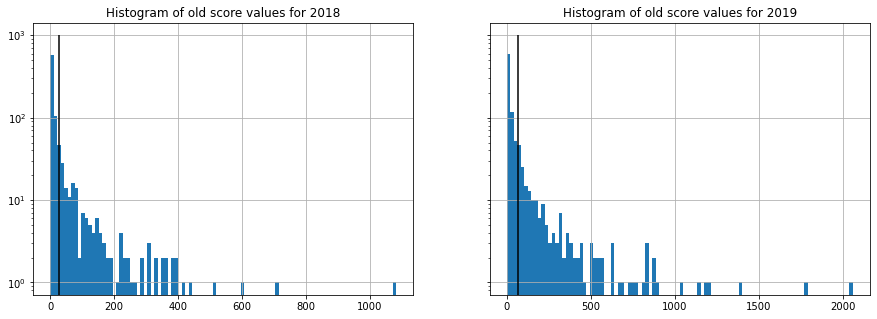

In [18]:
# Plots for some af-icf score distributions
fig1, ax1 = plt.subplots(1,2,figsize=(15,5), sharey=True)
af_icf_per_year.score_old.loc[af_icf_per_year.year=='2018'].hist(bins=100, ax=ax1[0])
ax1[0].vlines(af_icf_per_year.loc[af_icf_per_year.year=='2018'].score_old.
                  quantile(0.8), ymin=0, ymax=1000, color='black')

af_icf_per_year.loc[af_icf_per_year.year=='2019'].score_old.hist(bins=100, ax=ax1[1])
ax1[1].vlines(af_icf_per_year.loc[af_icf_per_year.year=='2019'].score_old.
              quantile(0.8), ymin=0, ymax=1000, color='black')

plt.yscale('log')
ax1[0].set_title('Histogram of old score values for 2018')
ax1[1].set_title('Histogram of old score values for 2019')
plt.show()

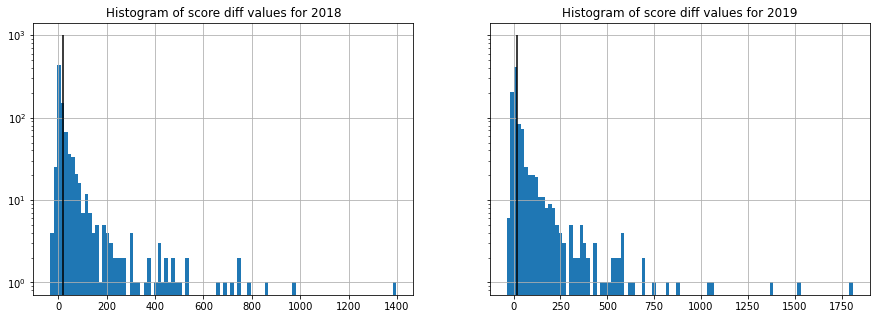

In [19]:
fig1, ax1 = plt.subplots(1,2,figsize=(15,5), sharey=True)
af_icf_per_year.score_diff.loc[af_icf_per_year.year=='2018'].hist(bins=100, ax=ax1[0])
ax1[0].vlines(af_icf_per_year.loc[af_icf_per_year.year=='2018'].score_diff.
                  quantile(0.65), ymin=0, ymax=1000, color='black')

af_icf_per_year.loc[af_icf_per_year.year=='2019'].score_diff.hist(bins=100, ax=ax1[1])
ax1[1].vlines(af_icf_per_year.loc[af_icf_per_year.year=='2019'].score_diff.
              quantile(0.65), ymin=0, ymax=1000, color='black')

plt.yscale('log')
ax1[0].set_title('Histogram of score diff values for 2018')
ax1[1].set_title('Histogram of score diff values for 2019')
plt.show()

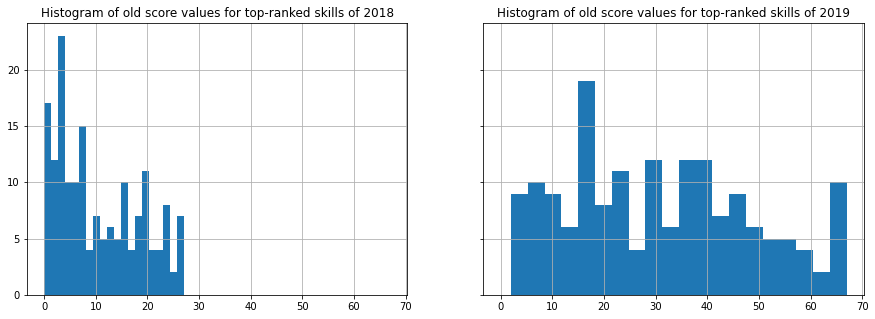

In [20]:
fig1, ax1 = plt.subplots(1,2,figsize=(15,5), sharey=True, sharex=True)
af_icf_top_ranks.score_old.loc[af_icf_top_ranks.year=='2018'].hist(bins=20, ax=ax1[0])

af_icf_top_ranks.loc[af_icf_top_ranks.year=='2019'].score_old.hist(bins=20, ax=ax1[1])

ax1[0].set_title('Histogram of old score values for top-ranked skills of 2018')
ax1[1].set_title('Histogram of old score values for top-ranked skills of 2019')
plt.show()

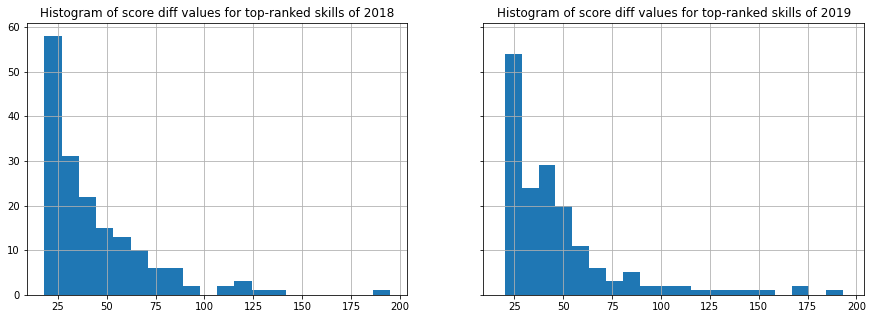

In [21]:
fig1, ax1 = plt.subplots(1,2,figsize=(15,5), sharey=True, sharex=True)
af_icf_top_ranks.score_diff.loc[af_icf_top_ranks.year=='2018'].hist(bins=20, ax=ax1[0])

af_icf_top_ranks.loc[af_icf_top_ranks.year=='2019'].score_diff.hist(bins=20, ax=ax1[1])

ax1[0].set_title('Histogram of score diff values for top-ranked skills of 2018')
ax1[1].set_title('Histogram of score diff values for top-ranked skills of 2019')
plt.show()

In [22]:
af_icf_per_year.shape

(2763, 5)

In [23]:
af_icf_top_ranks.loc[af_icf_top_ranks.year=='2019'].head(40)

,year,TagName,score_new,score_old,score_diff
2003,2019,kubernetes,245.0,52.0,193.0
2292,2019,social media (youtube),236.0,67.0,169.0
1948,2019,infrastructure-as-a-service (iaas),230.0,62.0,168.0
1893,2019,google ads,193.0,40.0,153.0
2169,2019,pl/sql,177.0,30.0,147.0
1620,2019,application security design,201.0,67.0,134.0
2285,2019,soap,197.0,66.0,131.0
2029,2019,managed security services (mss),140.0,23.0,117.0
2065,2019,microsoft office 365,171.0,57.0,114.0
2113,2019,network theorems,134.0,22.0,112.0


In [24]:
af_icf_top_ranks.loc[af_icf_top_ranks.TagName=='pytorch']

,year,TagName,score_new,score_old,score_diff
1295,2018,pytorch,19.0,0.0,19.0
2191,2019,pytorch,40.0,19.0,21.0


In [25]:
second_final_diffs = {year: set(sorted(af_icf_top_ranks.loc[af_icf_top_ranks.year==year].TagName.values.tolist())) 
                   for year in af_icf_top_ranks.year.unique()}

In [26]:
len(second_final_diffs['2018']), len(second_final_diffs['2019'])

(171, 166)

In [27]:
second_final_diffs

{'2018': {'adobe creative suite',
  'adobe indesign',
  'adobe marketo',
  'aml/cft',
  'ansible',
  'apache hbase',
  'apache hive',
  'apache kafka',
  'apache maven',
  'apache subversion (svn)',
  'apache tomcat',
  'api management system',
  'appdynamics',
  'application integration',
  'autocad',
  'automation testing',
  'autonomous vehicle',
  'aveva',
  'benchmarking',
  'bgp (border gateway protocol)',
  'blockchain technology',
  'business intelligence (bi) tools',
  'cad (computer aided design)',
  'caffe',
  'cisco webex',
  'computer systems',
  'computer vision',
  'confluence',
  'content delivery network (cdn)',
  'cryptocurrency',
  'cyber threat management',
  'd3.js',
  'data loss prevention',
  'data migration',
  'data quality control',
  'data science',
  'data structure',
  'data visualisation',
  'data wrangling',
  'data/text mining',
  'ddos',
  'deep learning',
  'devops',
  'digital platforms',
  'django',
  'doe troubleshooting',
  'e-mail marketing',
  'e

In [28]:
len(second_final_diffs['2018'].intersection(second_final_diffs['2019']))

74

### Computing the best baseline classifier

In [29]:
def compute_best_baseline(final_diff_dict, mode='topk'):
    """
    Trains the strong baseline, which reports the k best candidates for emergence as emerging. For details, 
    refer to the paper.
    """
    max_f1 = 0
    bestprec = 0
    bestrec = 0
    if mode == 'topk':
        besti = 350
    else:
        besti = 50
    initial_i = besti + 1
    for i in range(initial_i, initial_i+500, 10):
        if mode == 'topk':
            df1 = get_top_k_per_period(monthly_skill_data, i, 4)
            df1 = df1.loc[df1.year == '2017']
            df2 = get_top_k_per_period(monthly_skill_data, initial_i-1, 4)
            df2 = df2.loc[df2.year == '2017']

            another_baseline_set = set().union(*[set(df1.loc[df1.period==str(j)].TagName.values.tolist()).\
                                    difference(df2.loc[df2.period==str(j)].TagName.values.tolist()) 
                                                 for j in range(4)])
        else:
            another_baseline_set = set(af_icf_per_year.loc[(af_icf_per_year.year=='2018') &
                                      (af_icf_per_year.score_old < old_score_quantiles['2018'])].\
                                        sort_values('score_old', ascending=False).head(i).TagName.values.tolist())
        
        curr_tot = len(another_baseline_set)
        curr_tp = len(another_baseline_set.intersection(final_diff_dict['2018']))
        curr_ap = len(set(final_diff_dict['2018']))
        if curr_ap == 0 or curr_tot == 0:
            continue
        curr_prec = curr_tp / curr_tot
        curr_rec = curr_tp / curr_ap
        if curr_prec == 0 or curr_rec == 0:
            continue
        curr_f1 = 2*curr_prec*curr_rec / (curr_prec+curr_rec)
        print(i, curr_tot, curr_tp)
        if curr_f1 > max_f1:
            max_f1 = curr_f1
            bestprec = curr_prec
            bestrec = curr_rec
            besti = i
            
    return besti, max_f1, bestprec, bestrec

besti, max_f1, bestprec, bestrec = compute_best_baseline(second_final_diffs, mode='tfidf')
print(besti, max_f1, bestprec, bestrec)

51 51 35
61 61 41
71 71 46
81 81 50
91 91 54
101 101 59
111 111 66
121 121 68
131 131 71
141 141 77
151 151 79
161 161 83
171 171 86
181 181 90
191 191 95
201 201 96
211 211 100
221 221 102
231 231 106
241 241 107
251 251 114
261 261 116
271 271 118
281 281 120
291 291 123
301 301 126
311 311 131
321 321 133
331 331 135
341 341 136
351 351 138
361 361 141
371 371 142
381 381 143
391 391 144
401 401 145
411 411 149
421 421 152
431 431 152
441 441 152
451 451 152
461 461 153
471 471 154
481 481 155
491 491 157
501 501 159
511 511 160
521 521 161
531 531 161
541 541 162
311 0.5435684647302905 0.4212218649517685 0.7660818713450293


In [30]:
def get_common_keys_to_keep_topk(monthly_skill_data, larger_k, smaller_k, n_periods=4):
    years = monthly_skill_data.Date.apply(lambda x: x.split('-')[0]).unique()
    results = list()
    results_dict = dict()
    for year in years:
        df_candidate = get_top_k_per_period(monthly_skill_data, larger_k, n_periods)
        df_candidate = df_candidate.loc[df_candidate.year == year]
        df_already_emerged = get_top_k_per_period(monthly_skill_data, smaller_k, n_periods)
        df_already_emerged = df_already_emerged.loc[df_already_emerged.year == year]
        skill_set = set().union(*[set(df_candidate.loc[df_candidate.period==str(i)].TagName.values).\
                        difference(df_already_emerged.loc[df_already_emerged.period==str(i)].TagName.values) 
                                  for i in range(n_periods)])
        results_dict[year] = skill_set
        skill_set = [skill_name+'_'+year+'-'+str(int(year)+1) for skill_name in skill_set]
        results.extend(skill_set)
    return results, results_dict[max(years)]

def get_common_keys_to_keep_tfidf(monthly_skill_data, tfidf_data, quantile, k, col_to_use='score_old'):
    years = monthly_skill_data.Date.apply(lambda x: x.split('-')[0]).unique()
    results = list()
    results_dict = dict()
    for year in years:
        if year == min(years):
            continue
        skill_set = set(tfidf_data.loc[(tfidf_data.year==year)&
                       (tfidf_data[col_to_use] <= 
                        tfidf_data.loc[tfidf_data.year==year][col_to_use].quantile(quantile))].\
                            sort_values(col_to_use, ascending=False).head(k).TagName.values.tolist())
        results_dict[year] = skill_set
        skill_set = [skill_name+'_'+str(int(year)-1)+'-'+year for skill_name in skill_set]
        results.extend(skill_set)
    return results, results_dict[max(years)]

In [31]:
# common_keys_to_keep, skills_to_keep_eval = get_common_keys_to_keep_topk(monthly_skill_data, 461, 350, 4)
# definitely_not_emerging = get_definitely_not_emerging(monthly_skill_data, 350, n_periods=4)
common_keys_to_keep, skills_to_keep_eval = get_common_keys_to_keep_tfidf(
                                monthly_skill_data, af_icf_per_year, 0.8, 311)
non_negative_skills_to_keep, discard = get_common_keys_to_keep_tfidf(
                                monthly_skill_data, af_icf_per_year, 0.8, 2000)

In [32]:
common_keys_to_keep

['usability testing_2017-2018',
 'adobe indesign_2017-2018',
 'computational biology_2017-2018',
 'postgresql_2017-2018',
 'micro-services_2017-2018',
 'macromedia dreamweaver_2017-2018',
 'database security_2017-2018',
 'informatica_2017-2018',
 'swot analysis_2017-2018',
 'adobe phonegap_2017-2018',
 'ado.net_2017-2018',
 'apache subversion (svn)_2017-2018',
 'magento_2017-2018',
 'bluetooth_2017-2018',
 'market analysis_2017-2018',
 'mvvm_2017-2018',
 'data center infrastructure management_2017-2018',
 'e-mail marketing_2017-2018',
 'sdk_2017-2018',
 'annuity_2017-2018',
 'mac os_2017-2018',
 'network theorems_2017-2018',
 'mobile device management system_2017-2018',
 'penetration testing_2017-2018',
 'data cleaning_2017-2018',
 'game development_2017-2018',
 'universal mobile telecommunications service (umts)_2017-2018',
 'uml_2017-2018',
 'predictive analytics_2017-2018',
 'enterprise content management system (ecm)_2017-2018',
 'endpoint security_2017-2018',
 '3d modeling_2017-20

In [33]:
def get_positive_skills(gt_dict, time_periods):
    dict_for_df = {time_period_key: set(chain.from_iterable(
                    [gt_dict[k] for k in gt_dict if int(k) > int(time_period_key.split('-')[0])
                                                and int(k) <= int(time_period_key.split('-')[1])
                    ])) for time_period_key in time_periods}
    return dict_for_df

In [34]:
tp = {
    '2017-2018': (np.datetime64('2017-01-01'), np.datetime64('2018-01-01')),
    '2018-2019': (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')),
#     '2019-2020': (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
#     '2018-2020': (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
#     '2017-2019': (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')),
#     '2017-2020': (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))
}


positives_dict_gt = get_positive_skills(second_final_diffs, tp)
positives_dict_gt

{'2017-2018': {'adobe creative suite',
  'adobe indesign',
  'adobe marketo',
  'aml/cft',
  'ansible',
  'apache hbase',
  'apache hive',
  'apache kafka',
  'apache maven',
  'apache subversion (svn)',
  'apache tomcat',
  'api management system',
  'appdynamics',
  'application integration',
  'autocad',
  'automation testing',
  'autonomous vehicle',
  'aveva',
  'benchmarking',
  'bgp (border gateway protocol)',
  'blockchain technology',
  'business intelligence (bi) tools',
  'cad (computer aided design)',
  'caffe',
  'cisco webex',
  'computer systems',
  'computer vision',
  'confluence',
  'content delivery network (cdn)',
  'cryptocurrency',
  'cyber threat management',
  'd3.js',
  'data loss prevention',
  'data migration',
  'data quality control',
  'data science',
  'data structure',
  'data visualisation',
  'data wrangling',
  'data/text mining',
  'ddos',
  'deep learning',
  'devops',
  'digital platforms',
  'django',
  'doe troubleshooting',
  'e-mail marketing',

## Global preprocessing

In [35]:
tp = {
    '2017-2018': (np.datetime64('2017-01-01'), np.datetime64('2018-01-01')),
    '2018-2019': (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')),
}

### If using continuous ground truth

In [36]:
def get_af_icf_continuous_gt(af_icf_df, gt_type='rank'):
    if gt_type == 'pop':
        return af_icf_df.assign(output_score=af_icf_df.score_diff)
    else:
        af_icf_df = af_icf_df.copy()
        af_icf_df['rank_old'] = af_icf_df['score_old'].rank(ascending=False)
        af_icf_df['rank_new'] = af_icf_df['score_new'].rank(ascending=False)
        if gt_type == 'log_rank':
            return af_icf_df.assign(output_score=np.log(af_icf_df.rank_old) - np.log(af_icf_df.rank_new))
        else:
            return af_icf_df.assign(output_score=af_icf_df.rank_old - af_icf_df.rank_new)

In [37]:
y_reformatted = continuous_reformat_y(get_af_icf_continuous_gt(af_icf_per_year, 'pop'), 
                                      time_periods=tp, ref_col='output_score')

In [38]:
y_reformatted = {yr_key: y_reformatted[yr_key].
                 assign(aux_row_class=y_reformatted[yr_key].Skills.apply(lambda x: 
                                                             1 if x in positives_dict_gt[yr_key] else 0))
                            for yr_key in y_reformatted}

In [39]:
y_reformatted['2017-2018'].shape, y_reformatted['2018-2019'].shape

((880, 3), (969, 3))

### Run this if you want binarised ground truth

In [199]:
y_reformatted = {k: y_reformatted[k].rename(columns={'row_class': 'aux_row_class', 'aux_row_class': 'row_class'})
                for k in y_reformatted}

In [200]:
y_reformatted

{'2017-2018':       aux_row_class                       Skills  row_class
 684            72.0                         .net          0
 685             2.0                  3d graphics          0
 686             9.0                  3d modeling          0
 687            11.0                  a/b testing          0
 688             2.0                    ab initio          0
 ...             ...                          ...        ...
 2473           -4.0                   sqlalchemy          0
 2474           -2.0  virtual design construction          0
 2475           -1.0                    visualfea          0
 2476           -1.0        wi-fi protected setup          0
 2477           -1.0           windows clustering          0
 
 [880 rows x 3 columns],
 '2018-2019':       aux_row_class                       Skills  row_class
 1531          308.0                         .net          0
 1532           -5.0                  3d graphics          0
 1533           -2.0            

### Preprocessing

In [49]:
# feature_type_to_use = 'linreg_nointercept'
# params_to_use = {feature_type_to_use:{'degree':2}}

params_to_use = {'tsfresh':{}, 'linreg_nointercept':{'degree': 2}, 'orig': {}}

### First time running the notebook on your data? Start here.

In [50]:
# # # Run compute_total_poptype_mean with pop_type='log' (for the normalisation) on original ad df

# # # To get quarterly data (or data grouped together in any other divisor of 12), run this
# # # ts_mean_values = compute_total_poptype_mean(group_time_steps_together(skills_df, 3, True), pop_type='log')

# To get monthly data, run this
# ts_mean_values = compute_total_poptype_mean(skills_df, pop_type='raw', based_on='skill')

# # Run compile_all_feature_dfs with pop_type='log' on skills ad df

# # # To get quarterly data (or data grouped together in any other divisor of 12), run this
# # # features_df = compile_all_feature_dfs(group_time_steps_together(skills_df, 3, True), TIME_PERIODS, ts_mean_values, 
# # #                                           feature_types=['tsfresh', 'linreg_nointercept'], 
# # #                                           pop_type='log', smoothing=None, params=params_to_use)

# # To get monthly data, run this
# features_df = compile_all_feature_dfs(skills_df, tp, ts_mean_values, 
#                                           feature_types=['tsfresh'], 
#                                           pop_type='raw', smoothing='movingavg', params=params_to_use,
#                                           length_to_keep=None)

# # # Run create_train_test_split to create the training and test sets.



In [51]:
# with open('raw_features_df_and_mean_corrected_harsh_normalisation_2.pkl', 'wb') as f:
#     pickle.dump((features_df, ts_mean_values), f)

#### Already have your features extracted? Start here.

In [108]:
# with open('raw_orig_values_df_and_mean_corrected_harsh_normalisation.pkl', 'rb') as f:
#     features_df, ts_mean_values = pickle.load(f)

# with open('raw_features_df_and_mean_corrected_harsh_normalisation_2.pkl', 'rb') as f:
#     features_df, ts_mean_values = pickle.load(f)

# with open('bin_orig_features_df_and_mean_corrected_harsh_normalisation_2.pkl', 'rb') as f:
#     features_df, ts_mean_values = pickle.load(f)

# with open('bin_features_df_and_mean_corrected_harsh_normalisation_2.pkl', 'rb') as f:
#     features_df, ts_mean_values = pickle.load(f)

# with open('orig_values_df_and_mean_corrected_harsh_normalisation.pkl', 'rb') as f:
#     features_df, ts_mean_values = pickle.load(f)

with open('log_features_df_and_mean_corrected_harsh_normalisation_2.pkl', 'rb') as f:
    features_df, ts_mean_values = pickle.load(f)

# with open('log_features_halfyear_df_and_mean_corrected_harsh_normalisation.pkl', 'rb') as f:
#     features_df, ts_mean_values = pickle.load(f)

# with open('log_features_df_and_mean_corrected_quarterly.pkl', 'rb') as f:
#     features_df, ts_mean_values = pickle.load(f)

In [109]:
features_df['2018-2019'].head()

,tsfresh,Job Postings Raw
Skill,,
.net,"[1.0, 0.0, 0.0, 0.0, 124.24368704484377, 1596....",357
3d graphics,"[0.0, 0.0, 0.0, 0.0, -16.50489430852875, 29.08...",6
3d modeling,"[0.0, 0.0, 0.0, 1.0, -9.725949539345024, 11.80...",21
a/b testing,"[0.0, 0.0, 0.0, 0.0, -10.266569683489243, 14.0...",19
ab initio,"[0.0, 0.0, 0.0, 1.0, -19.45189907869005, 37.91...",2


In [110]:
len(features_df['2018-2019'].tsfresh.values[0])

779

In [111]:
tsfresh_feature_names = open('../tsfresh_6month_feature_names.txt', 'r').readlines()

In [112]:
tsfresh_feature_names = [x.strip() for x in tsfresh_feature_names]
tsfresh_feature_names

['variance_larger_than_standard_deviation',
 'has_duplicate_max',
 'has_duplicate_min',
 'has_duplicate',
 'sum_values',
 'abs_energy',
 'mean_abs_change',
 'mean_change',
 'mean_second_derivative_central',
 'median',
 'mean',
 'length',
 'standard_deviation',
 'variation_coefficient',
 'variance',
 'skewness',
 'kurtosis',
 'absolute_sum_of_changes',
 'longest_strike_below_mean',
 'longest_strike_above_mean',
 'count_above_mean',
 'count_below_mean',
 'last_location_of_maximum',
 'first_location_of_maximum',
 'last_location_of_minimum',
 'first_location_of_minimum',
 'percentage_of_reoccurring_values_to_all_values',
 'percentage_of_reoccurring_datapoints_to_all_datapoints',
 'sum_of_reoccurring_values',
 'sum_of_reoccurring_data_points',
 'ratio_value_number_to_time_series_length',
 'sample_entropy',
 'maximum',
 'minimum',
 'benford_correlation',
 'time_reversal_asymmetry_statistic__lag_1',
 'time_reversal_asymmetry_statistic__lag_2',
 'time_reversal_asymmetry_statistic__lag_3',
 'c3

#### Feature removal by name -- skip

In [52]:
features_to_remove = 'none'
# features_to_remove = 'freq,nonlinearity,change,autocorr'
# features_to_remove = 'freq,autocorr'
# features_to_remove = 'basics_plus'
# features_to_remove = 'all_but_basics'
# features_to_remove = 'superbasic'
# features_to_remove = 'basictripleplus'


# features_to_remove = BASIC_PLUSPLUS_FEATURES.union({
# #     x for x in tsfresh_feature_names if ('quantile__q_' in x and 'index' not in x)
# }).union({
# #     'count_above_mean', 'count_below_mean'
# }).union({
#     x for x in tsfresh_feature_names if 'time_reversal' in x
# }).union({
# #     x for x in tsfresh_feature_names if 'autocorr' in x
# }).union({
#     x for x in tsfresh_feature_names if 'number_peaks' in x
# }).union({
# #     x for x in tsfresh_feature_names if 'linear' in x
# }).difference({
# #     'variance_larger_than_standard_deviation'
# })

# features_to_remove = set()

# features_to_remove = set().union({
#     x for x in tsfresh_feature_names if 'linear' in x
# }).union({
#     x for x in tsfresh_feature_names if 'quantile__q' in x
# })

print(len(tsfresh_feature_names))
features_df, tsfresh_feature_names = \
                        remove_selected_features(features_df, feature_names=tsfresh_feature_names, 
                             colname='tsfresh', types=features_to_remove)
print(len(tsfresh_feature_names), len(features_df[list(features_df.keys())[0]].iloc[0]['tsfresh']))

779
779 779


In [53]:
tsfresh_feature_names

['variance_larger_than_standard_deviation',
 'has_duplicate_max',
 'has_duplicate_min',
 'has_duplicate',
 'sum_values',
 'abs_energy',
 'mean_abs_change',
 'mean_change',
 'mean_second_derivative_central',
 'median',
 'mean',
 'length',
 'standard_deviation',
 'variation_coefficient',
 'variance',
 'skewness',
 'kurtosis',
 'absolute_sum_of_changes',
 'longest_strike_below_mean',
 'longest_strike_above_mean',
 'count_above_mean',
 'count_below_mean',
 'last_location_of_maximum',
 'first_location_of_maximum',
 'last_location_of_minimum',
 'first_location_of_minimum',
 'percentage_of_reoccurring_values_to_all_values',
 'percentage_of_reoccurring_datapoints_to_all_datapoints',
 'sum_of_reoccurring_values',
 'sum_of_reoccurring_data_points',
 'ratio_value_number_to_time_series_length',
 'sample_entropy',
 'maximum',
 'minimum',
 'benford_correlation',
 'time_reversal_asymmetry_statistic__lag_1',
 'time_reversal_asymmetry_statistic__lag_2',
 'time_reversal_asymmetry_statistic__lag_3',
 'c3

#### Loading the original features

In [113]:
# with open('bin_orig_features_df_and_mean_corrected_harsh_normalisation_2.pkl', 'rb') as f:
#     log_orig_df, logmean_orig_df = pickle.load(f)
# with open('raw_orig_values_df_and_mean_corrected_harsh_normalisation.pkl', 'rb') as f:
#     log_orig_df, logmean_orig_df = pickle.load(f)
with open('orig_values_df_and_mean_corrected_harsh_normalisation.pkl', 'rb') as f:
    log_orig_df, logmean_orig_df = pickle.load(f)
    
for key in tp.keys():
    features_df[key] = features_df[key].join(log_orig_df[key]['orig'])
    features_df[key]['combined'] = features_df[key].apply(lambda x: np.concatenate([
                                                                        x['tsfresh'],
                                                                        x['orig']], axis=None), axis=1)
tsfresh_feature_names.extend([str(x) for x in range(1,1+len(features_df['2017-2018'].iloc[0].orig))])

In [114]:
# feature_type_to_use = 'tsfresh'
# feature_type_to_use = 'orig'
feature_type_to_use = 'combined'

In [115]:
# Remove features that have NaNs.
features_df, tsfresh_feature_names = \
            clean_nan_features(features_df, colname=feature_type_to_use,
                            feature_names=tsfresh_feature_names, keys_to_use=tp.keys())

In [116]:
# Run skills_to_indices to generate skill-period indices.
df_x_datapoints_with_ground_truth, df_y_all, df_x_all, datapoints_all_indices = \
                        skills_to_indices(features_df, y_reformatted)

     Skill                                            tsfresh  \
0     .net  [1.0, 0.0, 0.0, 0.0, 109.50947138354545, 1218....   
3414  .net  [1.0, 0.0, 0.0, 0.0, 260.79739878814263, 3184....   
4294  .net  [1.0, 0.0, 0.0, 0.0, 564.7824558446924, 11715....   
684   .net  [1.0, 0.0, 0.0, 0.0, 124.24368704484377, 1596....   
2445  .net  [1.0, 0.0, 0.0, 0.0, 428.2287441013936, 10128....   

      Job Postings Raw                                               orig  \
0                  285  [10.194920755452566, 10.78005136380496, 13.033...   
3414               642                                                NaN   
4294              1307                                                NaN   
684                357  [13.615389477865937, 12.397394785111498, 14.09...   
2445              1022                                                NaN   

                                               combined time_period  \
0     [1.0, 0.0, 0.0, 0.0, 109.50947138354545, 1218....   2017-2018   
3414

In [117]:
df_y_all.shape, df_x_datapoints_with_ground_truth.shape

((1849, 6), (1531, 8))

In [118]:
df_x_datapoints_with_ground_truth[feature_type_to_use].values[0].size

289

## Bulk training - binary ground truth

In [242]:
all_results = {random_state: normalise_pca_and_cross_validate_wrap(df_x_datapoints_with_ground_truth, df_y_all,
                          features_df, [10,20], n_selection_features=[40,60,80,100,120], test_proportion=0.3, 
                          based_on_year = True, also_based_on_skill=True,
                          pre_pca_norms = [RobustScaler(quantile_range=(2.5,97.5)),
                                           RobustScaler(quantile_range=(5,95))],
                           pre_clf_norms = [StandardScaler()],
                               verbose=False, features_col=feature_type_to_use,
                                  c_list=np.logspace(start=-4, stop=4, num=9, base=10), 
                                      quantiles=[1],
#                                                                    np.linspace(0.8, 1, num=5), 
                                                                   
                                       model_to_use='logreg', 
                                          eval_type='f1', is_bin=True,
                                              random_state=random_state,
                                                  common_keys_to_keep=non_negative_skills_to_keep)
                                                   for random_state in range(1,21)}

Random state: 1
BEFORE THE SPLIT:
1343800
(1483, 6)
Creating train/test split
2018-2019
Data on sampled test Y
218680
(228, 6)
Data on the whole thing
858176
(934, 6)
177152


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


combined


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [226]:
final_tfall_tfrawpopgrowth_logpop_fsandpca_65_70_1yearfulltest_1year_bin = all_results
with open('final_tfall_tfrawpopgrowth_logpop_fsandpca_65_70_1yearfulltest_1year_bin.pkl', 
          'wb') as f:
    pickle.dump(final_tfall_tfrawpopgrowth_logpop_fsandpca_65_70_1yearfulltest_1year_bin, f)



## Bulk training - continuous ground truth

In [97]:
all_continuous_results = {random_state: normalise_pca_and_cross_validate_wrap(
                            df_x_datapoints_with_ground_truth, df_y_all,
                              features_df, [10,20], n_selection_features=[40,60,80,100,120], test_proportion=0.3, 
                              based_on_year = True, also_based_on_skill=False,
                              pre_pca_norms = [RobustScaler(quantile_range=(2.5,97.5)),
                                               RobustScaler(quantile_range=(5,95))],
                               pre_clf_norms = [StandardScaler()],
                                   verbose=False, features_col=feature_type_to_use,
                                      c_list=np.logspace(start=-4, stop=4, num=9, base=10), 
                                          quantiles=
                                               [1], 
                                           model_to_use='linreg', 
                                              eval_type='rmse', is_bin=False,
                                                  random_state=random_state,
                                                      common_keys_to_keep=common_keys_to_keep)
                                                       for random_state in range(1,2)}


Random state: 1
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 26.614176218258798
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 27.99371249000443
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 26.899800037077874
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 27.742511982790575
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 26.71839646282474
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 27.53270353698927
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 26.272301617643926
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 27.14281958055374
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 26.56076413969256
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
Results: rmse = 26.81807951524784
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 26.59179813921625
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 28.03723650079637
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 27.01413384889533
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 27.604914660741468
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 26.608281188368817
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 27.323670319960126
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 26.445086350882104
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 27.190092810228805
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 27.170308082454852
BEFORE THE SPLIT:
569590
(622, 6)
Creating train/test split
2018-2019
Data on sampled test Y
287423
(311, 6)
Data on the whole thing
569590
(622, 6)
287423
tsfresh


/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Model with: 
Pre-norm:
RobustScaler(quantile_range=(5, 95))
Post-norm:
StandardScaler()
Results: rmse = 27.052675286811507
**************** Best: 
Model with: 
Pre-norm:
RobustScaler(quantile_range=(2.5, 97.5))
Post-norm:
StandardScaler()
PCA model:
[PCA(n_components=10), SelectKBest(k=100, score_func=<function f_regression at 0x127c6ac10>)]
Results: rmse = -26.272301617643926
Evaluation on train/test: 
Test: 
(array([3.24797459e+01, 1.51421175e+01, 2.58828453e+01, 4.92049126e+01,
       2.85618219e+01, 7.09679767e+01, 4.76240685e+01, 4.10963552e+01,
       2.10102380e+01, 1.45095850e+01, 1.31229342e+01, 1.20771378e+02,
       2.41049933e+01, 6.18528192e+01, 8.35721030e+00, 3.68089453e+00,
       5.53498247e+01, 1.31102290e+01, 1.59945090e+01, 2.12992122e+01,
       9.34594749e+01, 5.47011867e+00, 7.31158385e+01, 2.60907638e+01,
       1.43898806e-01, 3.37595848e+01, 1.19605901e+01, 4.70167957e+01,
       7.97194244e+01, 5.84197738e+00, 1.50967881e+01, 1.22841267e+01,
       6.60193607

In [98]:
limited_final_oneclf_tfall_tfrawpopgrowth_logpop_fsandpca_65_80_halfyearfulltest_1year_cont = all_continuous_results
with open('limited_final_oneclf_tfall_tfrawpopgrowth_logpop_fsandpca_65_80_halfyearfulltest_1year_cont.pkl', 'wb') as f:
    pickle.dump(limited_final_oneclf_tfall_tfrawpopgrowth_logpop_fsandpca_65_80_halfyearfulltest_1year_cont, f)
    
    
    


In [59]:
all_continuous_results = \
    pickle.load(open('final_oneclf_tfall_tfrawpopgrowth_logpop_fsandpca_65_80_1yearfulltest_1year_cont.pkl', 'rb'))

# Model interpretation

In [60]:
best_model = all_continuous_results[1][0][0][0]
best_q = all_continuous_results[1][0][0][2]
pca_model = all_continuous_results[1][0][0][6]
best_rawpop_upper = all_continuous_results[1][0][0][4]

## Feature weights
These are the raw weights. With a pre- and post-PCA normalised set of features, these are good indicators of a feature's importance. A positive coefficient means that datapoints with larger values in that feature are more likely to be classified as positive, whereas a negative coefficient means that those are more likely to be classified as negative. The unintuitive side of this fact is that the values of positive class datapoints for a feature with a negative coefficient could be larger negative numbers than the values of the negative class datapoints for said feature. Either way, these are very useful, but an alternative way of interpreting the discriminative power of each feature to the positive class can be seen in the next section.

In [67]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(interpret_model(best_model[0], tsfresh_feature_names, pca_model=pca_model[0], n_features=None,
                           dataframes=None, 
                            normaliser=best_model[1]))
# interpret_model(best_model[0], FEATURE_NAMES[feature_type_to_use])

,Name,Score,Features
1,0,9.399109,"[(median, 0.1774953924816661), (skewness, 0.17657650171237324), (variation_coefficient, 0.176127826327677), (variance, 0.17462336997182654), (mean_second_derivative_central, 0.17437944786533946), (kurtosis, 0.17390129480029845), (variance_larger_than_standard_deviation, 0.1735270916109132), (benford_correlation, 0.17352709161091312), (has_duplicate_min, 0.17352709161091304), (time_reversal_asymmetry_statistic__lag_1, -0.17343437436018172), (mean_abs_change, 0.1722492672082849), (first_location_of_maximum, 0.171877799670413), (last_location_of_maximum, 0.170974816684256), (longest_strike_above_mean, 0.17058607212547328), (longest_strike_below_mean, 0.17021408455791462), (abs_energy, 0.1699035933406005), (sum_of_reoccurring_data_points, 0.1699035933406005), (has_duplicate_max, 0.1699035933406005), (absolute_sum_of_changes, 0.1697095403721052), (standard_deviation, 0.16926721441640186)]"
7,6,2.339920,"[(c3__lag_2, -0.5182768550317285), (cid_ce__normalize_True, 0.31800293648577493), (has_duplicate, -0.3152763493751868), (minimum, -0.28570342160457834), (last_location_of_minimum, 0.2494643651205643), (sum_values, -0.24634575231946787), (sum_of_reoccurring_values, 0.21058407534642348), (has_duplicate_max, 0.18712467882676018), (abs_energy, 0.18712467882676012), (sum_of_reoccurring_data_points, 0.18712467882676012), (standard_deviation, -0.1714605563650751), (ratio_value_number_to_time_series_length, -0.1477900897850937), (time_reversal_asymmetry_statistic__lag_3, 0.14568728777835685), (mean_abs_change, -0.1356735138400702), (mean, -0.12461187610446368), (absolute_sum_of_changes, -0.10907197823716565), (percentage_of_reoccurring_datapoints_to_all_datapoints, -0.08663089351223176), (count_below_mean, -0.08025261500528866), (last_location_of_maximum, -0.08006414888566998), (first_location_of_maximum, -0.07970092960128335)]"
2,1,1.255071,"[(minimum, 0.319186426182637), (ratio_value_number_to_time_series_length, 0.30903649588931753), (maximum, 0.27971491695262946), (c3__lag_1, 0.26998482191377077), (sum_of_reoccurring_values, 0.2580678831778548), (mean_change, 0.23097482024263868), (sum_values, 0.21665785367045615), (has_duplicate, 0.21110680871666365), (abs_energy, 0.19158758653852495), (sum_of_reoccurring_data_points, 0.19158758653852495), (has_duplicate_max, 0.1915875865385249), (c3__lag_3, -0.17619722161934376), (count_above_mean, -0.1667839954754296), (count_below_mean, -0.14091085155150757), (absolute_sum_of_changes, -0.1381281131478795), (first_location_of_minimum, -0.13744262362892967), (percentage_of_reoccurring_values_to_all_values, -0.13286037622656185), (percentage_of_reoccurring_datapoints_to_all_datapoints, -0.13157450903628165), (last_location_of_maximum, -0.12609862352516907), (first_location_of_maximum, -0.12238699705608311)]"
4,3,0.523501,"[(c3__lag_2, -0.7217355599345958), (sum_values, 0.3147629176781831), (time_reversal_asymmetry_statistic__lag_2, -0.2940826704474464), (sum_of_reoccurring_data_points, -0.2177851311938348), (has_duplicate_max, -0.2177851311938348), (abs_energy, -0.2177851311938348), (cid_ce__normalize_True, -0.20497140043140655), (mean_change, -0.1591748305027057), (minimum, 0.14041011364028227), (maximum, 0.13684242542668845), (has_duplicate, 0.1125679760133977), (count_above_mean, 0.08328997598618001), (c3__lag_1, -0.07961511629134746), (standard_deviation, 0.06954626571309445), (mean, 0.06623856391399847), (last_location_of_minimum, -0.06622371611197447), (c3__lag_3, 0.041021915443021244), (median, 0.04001194695226248), (sum_of_reoccurring_values, -0.021487309423219036), (first_location_of_maximum, -0.01583654663296868)]"
6,5,-0.252662,"[(ratio_value_number_to_time_series_length, -0.41840771469726334), (minimum, -0.4108637825263156), (has_duplicate, 0.384649226842487), (sum_values, 0.3723561123479727), (time_reversal_asymmetry_statistic__lag_2, 0.32698040297405206), (sum_of_reoccurring_values, -0.21251932825115852), (standard_deviation, 0.17100610400851532), (mean_

Let's compute an ad-hoc importance measure for each _original_ feature.

In [69]:
from itertools import chain

interpretations = interpret_model(best_model[0], tsfresh_feature_names, pca_model=pca_model[0], n_features=None,
                           dataframes=None, 
                            normaliser=best_model[1]).drop(0, axis=0)
interpretations['Features'] = interpretations.apply(lambda x: [(y[0], y[1]*x['Score']) for y in x['Features']], 
                                                   axis=1)
important_originals = list(chain.from_iterable(interpretations['Features'].values.tolist()))
important_originals = pd.DataFrame({'Original Feature': [x[0] for x in important_originals], 
                                    'Ad-hoc Importance': [x[1] for x in important_originals]})
important_originals = important_originals.groupby('Original Feature').\
                                sum().sort_values('Ad-hoc Importance', ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(important_originals)

,Ad-hoc Importance
Original Feature,
cid_ce__normalize_True,3.260370
last_location_of_minimum,3.041301
longest_strike_above_mean,1.819125
time_reversal_asymmetry_statistic__lag_2,1.771157
skewness,1.746095
kurtosis,1.721840
longest_strike_below_mean,1.704476
minimum,1.490590
variance_larger_than_standard_deviation,1.470279


In [73]:
important_originals.to_csv('feature_importance.csv')

# Evaluation

In [119]:
# current_results_file = pickle.load(open(
#     'final_tfall_tfrawpopgrowth_logpop_fsandpca_65_70_1yearfulltest_1year_bin.pkl', 
#     'rb'))

current_results_file = pickle.load(open(
    'final_oneclf_tfall_tfrawpopgrowth_logpop_fsandpca_65_80_1yearfulltest_1year_cont.pkl', 'rb'))



In [120]:
return_pred_df = True

# evals = {
#     i: test_eval_for_wrapped_results(df_x_datapoints_with_ground_truth, df_y_all, current_results_file[i][0], 
#                                  current_results_file[i][1], random_state=i, feature_col=feature_type_to_use,
#                                      test_proportion=0.3, based_on_year=True, also_based_on_skill=True,
#                                          skills_to_ignore=None, 
#                                            pca_first=False, n_selection_features=None,
#                                              skills_to_keep=non_negative_skills_to_keep, 
#                                                 baselines_to_test={'previousyear': second_final_diffs['2018'],
#                                                                    'belowupperbound': common_keys_to_keep}, 
#                                                      return_pred_df=return_pred_df, is_binary=True, 
#                                                      binarisation_tools =
#                                      [
#                                         [second_final_diffs['2018'], second_final_diffs['2019']],
#                                         None, None]
#                                     , eval_type='prfs')
#     for i in range(1,len(current_results_file)+1)
# }

evals = {
    i: test_eval_for_wrapped_results(df_x_datapoints_with_ground_truth, df_y_all, current_results_file[i][0], 
                                 current_results_file[i][1], random_state=i, feature_col=feature_type_to_use,
                                     test_proportion=0.3, based_on_year=True, also_based_on_skill=False,
                                         skills_to_ignore=None, 
                                           pca_first=False, n_selection_features=None,
                                             skills_to_keep=non_negative_skills_to_keep, 
                                                baselines_to_test={'previousyear': second_final_diffs['2018'],
                                                                   'belowupperbound': common_keys_to_keep}, 
                                                     return_pred_df=return_pred_df, is_binary=False,
                                    binarisation_tools=[
                                        [second_final_diffs['2018'], second_final_diffs['2019']],
                                        [af_icf_per_year.loc[(af_icf_per_year.year=='2018') & 
                                                             (af_icf_per_year.score_old <= 
                                                              old_score_quantiles['2018'])].TagName.values,
                                         af_icf_per_year.loc[(af_icf_per_year.year=='2019') & 
                                                             (af_icf_per_year.score_old <= 
                                                              old_score_quantiles['2019'])].TagName.values],
                                        [0.65, 0.65]], eval_type='prfs')
    for i in range(1,len(current_results_file)+1)
}

if return_pred_df:
    predictions = {i:evals[i][1] for i in evals}
    evals = {i: evals[i][0] for i in evals}

((Ridge(alpha=100.0), StandardScaler()), 100.0, 1, -21.809493252388876, {'2017-2018': 1082.0, '2018-2019': 2058.0, '2019-2020': 3867.0, '2018-2020': 5925.0, '2017-2019': 3140.0, '2017-2020': 7007.0}, RobustScaler(quantile_range=(2.5, 97.5)), [PCA(n_components=20), SelectKBest(k=100, score_func=<function f_regression at 0x127c6ac10>)])
1
False
7
BEFORE THE SPLIT:
1708476
(1849, 6)
Creating train/test split
2018-2019
Data on sampled test Y
894461
(969, 6)
Data on the whole thing
1708476
(1849, 6)
782632
SelectKBest(k=100, score_func=<function f_regression at 0x127c6ac10>)
Yes binarisation
156998
['a/b testing', 'adobe after effects', 'adobe indesign', 'adobe marketo', 'adobe premiere pro', 'ajax', 'amazon redshift', 'aml/cft', 'animation', 'apache kafka', 'apache maven', 'apache struts', 'apache subversion (svn)', 'apache tomcat', 'appdynamics', 'application integration', 'application security design', 'as400 system', 'asp', 'augmented/virtual reality', 'autocad', 'automation solution', 

In [121]:
common_keys_to_keep

['usability testing_2017-2018',
 'adobe indesign_2017-2018',
 'computational biology_2017-2018',
 'postgresql_2017-2018',
 'micro-services_2017-2018',
 'macromedia dreamweaver_2017-2018',
 'database security_2017-2018',
 'informatica_2017-2018',
 'swot analysis_2017-2018',
 'adobe phonegap_2017-2018',
 'ado.net_2017-2018',
 'apache subversion (svn)_2017-2018',
 'magento_2017-2018',
 'bluetooth_2017-2018',
 'market analysis_2017-2018',
 'mvvm_2017-2018',
 'data center infrastructure management_2017-2018',
 'e-mail marketing_2017-2018',
 'sdk_2017-2018',
 'annuity_2017-2018',
 'mac os_2017-2018',
 'network theorems_2017-2018',
 'mobile device management system_2017-2018',
 'penetration testing_2017-2018',
 'data cleaning_2017-2018',
 'game development_2017-2018',
 'universal mobile telecommunications service (umts)_2017-2018',
 'uml_2017-2018',
 'predictive analytics_2017-2018',
 'enterprise content management system (ecm)_2017-2018',
 'endpoint security_2017-2018',
 '3d modeling_2017-20

In [122]:
evals

{1: {'test_unagg': (0.5432098765432098,
   0.7951807228915663,
   0.6454767726161369,
   None),
  'test_baseline_unagg': (0.17131062951496387, 1.0, 0.29251101321585904, None),
  'train_unagg': (0.526595744680851,
   0.5789473684210527,
   0.5515320334261837,
   None),
  'train_baseline_unagg': (0.1943181818181818, 1.0, 0.3254043767840152, None),
  'previousyear': (0.5967741935483871,
   0.4457831325301205,
   0.5103448275862069,
   None),
  'belowupperbound': (0.45980707395498394,
   0.8614457831325302,
   0.59958071278826,
   None)}}

In [123]:
df_x_datapoints_with_ground_truth.shape

(1531, 8)

In [124]:
def one_confidence_interval(l, method='quantile'):
    if method == 'quantile':
        return np.quantile(l, 0.05), np.median(l), np.quantile(l, 0.95)
    else:
        return np.mean(l) - 2*np.std(l), np.mean(l), np.mean(l) + 2*np.std(l)

def compute_confidence_intervals_dict(eval_results, rounding=3):
    lists_dict = {eval_key:[x[eval_key] for x in eval_results.values()] for eval_key in evals[1].keys()}
    conf_int_dict = {eval_key:{'prec': one_confidence_interval([x[0] for x in lists_dict[eval_key]]),
                               'recall': one_confidence_interval([x[1] for x in lists_dict[eval_key]]),
                               'f1': one_confidence_interval([x[2] for x in lists_dict[eval_key]])}
                    for eval_key in lists_dict}
    if rounding != -1:
        conf_int_dict = {eval_key: {score_key: tuple([round(x, 3) for x in conf_int_dict[eval_key][score_key]])
                                    for score_key in conf_int_dict[eval_key]} for eval_key in conf_int_dict}
    return conf_int_dict

def plot_conf_interval(eval_results):
    lists_dict = {eval_key:[x[eval_key] for x in eval_results.values()] for eval_key in evals[1].keys()}
    conf_int_dict = [[(eval_key,x[2]) for x in lists_dict[eval_key]] for eval_key in lists_dict]
    conf_int_dict = list(chain.from_iterable(conf_int_dict))
    df = pd.DataFrame({'Classifier': [x[0] for x in conf_int_dict], 'F1': [x[1] for x in conf_int_dict]})
    map_dict = {'test_unagg': 'Logpop + two-step', 
                'belowupperbound': 'Below Upper Bound', 
                'previousyear': 'Previous Year'}
    df = df.loc[df.Classifier.apply(lambda x: x in map_dict)]
    df['Classifier'] = df['Classifier'].apply(lambda x: map_dict[x])
    
    plt.figure(figsize=(16,15))
    sns.boxplot(x='Classifier', y='F1', data=df)
    fs = 15
    plt.xlabel('Classifier',fontsize=fs)
    plt.ylabel('F1 score',fontsize=fs)
    plt.title('Boxplots for F1 score of reference classifier vs baselines', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.show()
    
    

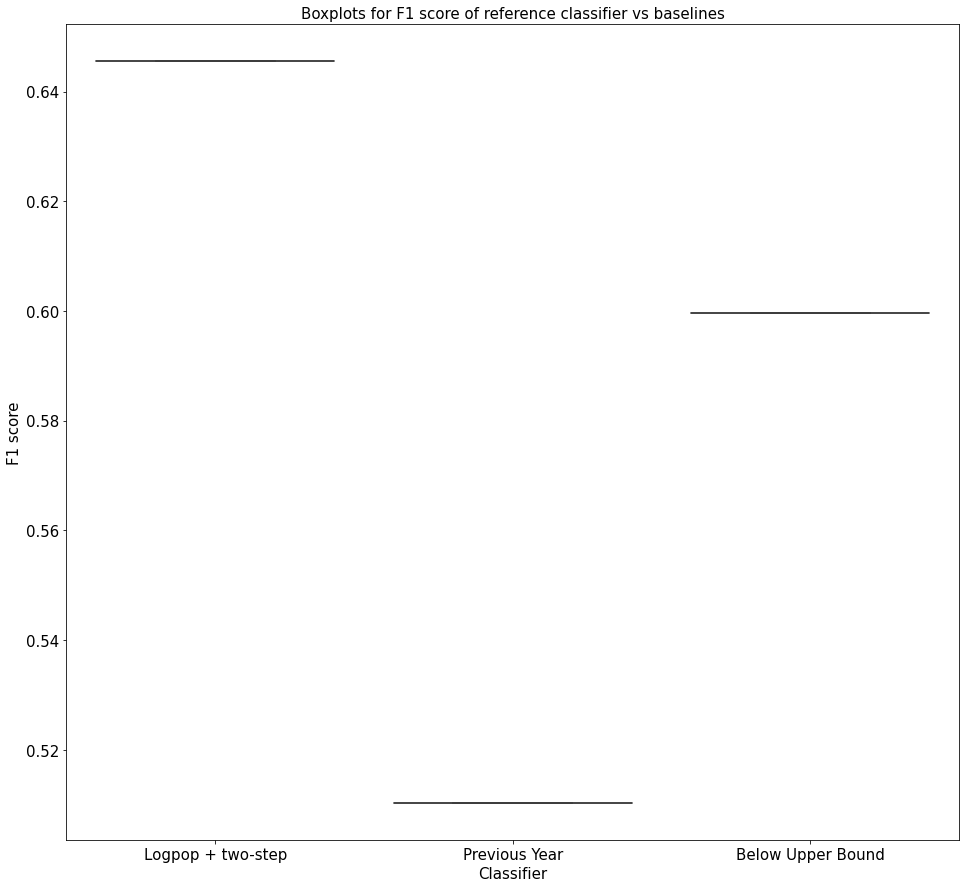

In [125]:
plot_conf_interval(evals)

In [126]:
from scipy.stats import kruskal
def add_small_random_noise(l):
    return [x+np.random.normal(loc=0,scale=0.000000001) for x in l]

def perform_hypothesis_test_for_performance_measures(eval_results):
    lists_dict = {eval_key:[x[eval_key] for x in eval_results.values()] for eval_key in evals[1].keys()}
    stat_test_dict = dict()
    for base_name in ['test', 'train']:
        for agg_or_not in ['_unagg']:
            stat_test_dict[base_name+agg_or_not] = {
                'prec': kruskal(add_small_random_noise([x[0] for x in lists_dict[base_name+agg_or_not]]),
                                add_small_random_noise([x[0] for x in lists_dict[base_name+'_baseline'+agg_or_not]])),
                'recall': kruskal(add_small_random_noise([x[1] for x in lists_dict[base_name+agg_or_not]]),
                                add_small_random_noise([x[1] for x in lists_dict[base_name+'_baseline'+agg_or_not]])),
                'f1': kruskal(add_small_random_noise([x[2] for x in lists_dict[base_name+agg_or_not]]),
                                add_small_random_noise([x[2] for x in lists_dict[base_name+'_baseline'+agg_or_not]]))}
    for baseline_name in [x for x in lists_dict.keys() if 'train' not in x and 'test' not in x]:
        stat_test_dict['test_vs_'+baseline_name] = {
                'prec': kruskal(add_small_random_noise([x[0] for x in lists_dict['test_unagg']]),
                                add_small_random_noise([x[0] for x in lists_dict[baseline_name]])),
                'recall': kruskal(add_small_random_noise([x[1] for x in lists_dict['test_unagg']]),
                                add_small_random_noise([x[1] for x in lists_dict[baseline_name]])),
                'f1': kruskal(add_small_random_noise([x[2] for x in lists_dict['test_unagg']]),
                                add_small_random_noise([x[2] for x in lists_dict[baseline_name]]))}
    return stat_test_dict



In [127]:
print(compute_confidence_intervals_dict(evals))

{'test_unagg': {'prec': (0.543, 0.543, 0.543), 'recall': (0.795, 0.795, 0.795), 'f1': (0.645, 0.645, 0.645)}, 'test_baseline_unagg': {'prec': (0.171, 0.171, 0.171), 'recall': (1.0, 1.0, 1.0), 'f1': (0.293, 0.293, 0.293)}, 'train_unagg': {'prec': (0.527, 0.527, 0.527), 'recall': (0.579, 0.579, 0.579), 'f1': (0.552, 0.552, 0.552)}, 'train_baseline_unagg': {'prec': (0.194, 0.194, 0.194), 'recall': (1.0, 1.0, 1.0), 'f1': (0.325, 0.325, 0.325)}, 'previousyear': {'prec': (0.597, 0.597, 0.597), 'recall': (0.446, 0.446, 0.446), 'f1': (0.51, 0.51, 0.51)}, 'belowupperbound': {'prec': (0.46, 0.46, 0.46), 'recall': (0.861, 0.861, 0.861), 'f1': (0.6, 0.6, 0.6)}}


In [128]:
perform_hypothesis_test_for_performance_measures(evals)

{'test_unagg': {'prec': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'recall': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'f1': KruskalResult(statistic=1.0, pvalue=0.31731050786291115)},
 'train_unagg': {'prec': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'recall': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'f1': KruskalResult(statistic=1.0, pvalue=0.31731050786291115)},
 'test_vs_previousyear': {'prec': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'recall': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'f1': KruskalResult(statistic=1.0, pvalue=0.31731050786291115)},
 'test_vs_belowupperbound': {'prec': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'recall': KruskalResult(statistic=1.0, pvalue=0.31731050786291115),
  'f1': KruskalResult(statistic=1.0, pvalue=0.31731050786291115)}}

In [129]:
predictions[1]

,level_0,row_class,Skills,aux_row_class,common_key,common_index,cont_pred,pred
1,1,0,3d graphics,0,3d graphics_2018-2019,3,-2.448034,0
2,2,0,3d modeling,0,3d modeling_2018-2019,5,26.255653,1
3,3,1,a/b testing,1,a/b testing_2018-2019,7,8.268157,0
4,914,0,ab initio,0,ab initio_2018-2019,9,8.360006,0
6,5,0,accounting information systems,0,accounting information systems_2018-2019,12,0.000000,0
...,...,...,...,...,...,...,...,...
964,910,0,zeplin,0,zeplin_2018-2019,1840,8.477397,0
965,968,0,zeppelin,0,zeppelin_2018-2019,1842,5.370377,0
966,911,0,zeromq,0,zeromq_2018-2019,1844,10.834112,0
967,912,0,zigbee,0,zigbee_2018-2019,1846,7.937593,0


In [130]:
predictions = {i: predictions[i].assign(indicator=1) for i in predictions}
combined_preds = {i: predictions[i][['pred', 'row_class', 'cont_pred', 'indicator', 'common_key', 'Skills']]
                 for i in predictions}
combined_preds = pd.concat(list(combined_preds.values())).groupby(['common_key', 'row_class', 'Skills']).\
                                                                                            sum().reset_index()
combined_preds['pred'] = combined_preds.apply(lambda x: 1 if x['pred'] >= x['indicator']/2 else 0, axis=1)
combined_preds['cont_pred'] = combined_preds.apply(lambda x: x['cont_pred'] / x['indicator'], axis=1)

In [131]:
# sorted_cont_preds = \
#                 predictions[1].sort_values('cont_pred', ascending=False).reset_index().drop('index', axis=1)
sorted_cont_preds = combined_preds.sort_values('cont_pred', ascending=False).reset_index().drop('index', axis=1)

In [132]:
def merge_pred_df(pred_df, growths, year='2019'):
    pred_df_merged = pd.merge(pred_df, growths.loc[growths.year==year, ['TagName', 'score_diff', 'score_old']], 
                             left_on='Skills', right_on='TagName').drop(columns=['TagName'])
    return pred_df_merged
def show_false_positives(pred_df, growths, year='2019'):
    pred_df_merged = merge_pred_df(pred_df, growths, year)
    return pred_df_merged.loc[(pred_df_merged.row_class==0)&(pred_df_merged.pred==1)]
def show_false_negatives(pred_df, growths, year='2019'):
    pred_df_merged = merge_pred_df(pred_df, growths, year)
    return pred_df_merged.loc[(pred_df_merged.row_class==1)&(pred_df_merged.pred==0)]
def show_positives(pred_df, growths, year='2019'):
    pred_df_merged = merge_pred_df(pred_df, growths, year)
    return pred_df_merged.loc[(pred_df_merged.pred==1)]
def show_true_positives(pred_df, growths, year='2019'):
    pred_df_merged = merge_pred_df(pred_df, growths, year)
    return pred_df_merged.loc[(pred_df_merged.row_class==1)&(pred_df_merged.pred==1)]

In [133]:
our_preds = sorted_cont_preds.copy()
belowu_preds = sorted_cont_preds.copy().assign(pred=sorted_cont_preds.common_key.apply(
                    lambda x: 1 if x in common_keys_to_keep else 0))
lastyear_preds = sorted_cont_preds.copy().assign(pred=sorted_cont_preds.Skills.apply(
                    lambda x: 1 if x in second_final_diffs['2018'] else 0))

In [134]:
our_preds.pred.sum()

243

In [135]:
evaluate_results(our_preds.pred.values.tolist(), our_preds.row_class.values.tolist(), 'tpfpfn')

(132, 111, 34)

In [136]:
belowu_preds.pred.sum()

311

In [137]:
evaluate_results(belowu_preds.pred.values.tolist(), belowu_preds.row_class.values.tolist(), 'tpfpfn')

(143, 168, 23)

In [138]:
diff_quantiles

{'2018': 18.0, '2019': 20.0, '2020': -10.0}

In [139]:
fp_df = show_false_positives(our_preds, af_icf_per_year)
fn_df = show_false_negatives(our_preds, af_icf_per_year)
pos_df = show_positives(our_preds, af_icf_per_year)
tp_df = show_true_positives(our_preds, af_icf_per_year)

In [140]:
baseline_tp_df = show_true_positives(belowu_preds, af_icf_per_year)

In [141]:
pos_df.shape

(243, 8)

In [142]:
merged_temp = merge_pred_df(predictions[1], af_icf_per_year).sort_values('score_old', ascending=False).\
        reset_index().drop(columns=['index', 'level_0'])
merged_temp.loc[merged_temp.Skills.apply(lambda x: x in ['amazon redshift', 'keras', 'vue.js', 'ibm db2'])]

,row_class,Skills,aux_row_class,common_key,common_index,cont_pred,pred,indicator,score_diff,score_old
136,1,vue.js,1,vue.js_2018-2019,1755,36.014509,1,1,54.0,27.0
180,1,ibm db2,1,ibm db2_2018-2019,809,22.837318,1,1,55.0,21.0
223,1,keras,1,keras_2018-2019,929,10.599940,0,1,34.0,16.0
352,1,amazon redshift,1,amazon redshift_2018-2019,72,17.855422,1,1,39.0,8.0


In [143]:
merged_temp.head(10)

,row_class,Skills,aux_row_class,common_key,common_index,cont_pred,pred,indicator,score_diff,score_old
0,1,wireframes,1,wireframes_2018-2019,1801,204.149159,1,1,60.0,67.0
1,1,social media (youtube),1,social media (youtube)_2018-2019,1536,101.039662,1,1,169.0,67.0
2,1,application security design,1,application security design_2018-2019,172,120.108770,1,1,134.0,67.0
3,1,soap,1,soap_2018-2019,1524,141.146746,1,1,131.0,66.0
4,1,google analytics,1,google analytics_2018-2019,739,151.026940,1,1,38.0,66.0
5,1,financial analysis,1,financial analysis_2018-2019,661,142.428015,1,1,26.0,66.0
6,1,database optimisation,1,database optimisation_2018-2019,492,106.407916,1,1,42.0,66.0
7,1,siem platforms,1,siem platforms_2018-2019,1503,124.510265,1,1,49.0,66.0
8,1,internet information services,1,internet information services_2018-2019,852,168.887550,1,1,69.0,65.0
9,1,autocad,1,autocad_2018-2019,200,112.778008,1,1,33.0,64.0


In [83]:
def compute_roc_values(df, col, ref_col='row_class'):
    threshold_range = list(range(1, df.shape[0], 1))
    df = df.sort_values(col, ascending=False).reset_index().drop(columns=['index'])
    results_y = [0.0]
    results_x = [0.0]
    
    for threshold in threshold_range:
        rest = df.shape[0] - threshold
        current_pos = df.head(threshold)
        current_neg = df.tail(rest)
        tp = current_pos.apply(lambda x: 1 if x[ref_col] == 1 else 0, axis=1).sum()
        fp = threshold - tp
        tn = current_neg.apply(lambda x: 1 if x[ref_col] == 0 else 0, axis=1).sum()
        fn = rest - tn
        results_y.append((tp/(tp+fn)))
        results_x.append((fp/(tn+fp)))
        
    results_x.append(1.0)
    results_y.append(1.0)
    
    return results_x, results_y

def integrate_roc(x,y):
    result = 0
    for i in range(1,len(x)):
        result += y[i]*(x[i]-x[i-1])
    return result

In [137]:
roc_our_clf = compute_roc_values(merged_temp, 'cont_pred')
roc_baseline = compute_roc_values(merged_temp, 'score_old')

In [138]:
integrate_roc(roc_our_clf[0],roc_our_clf[1]), integrate_roc(roc_baseline[0],roc_baseline[1])

(0.8449214205430516, 0.878956086210637)

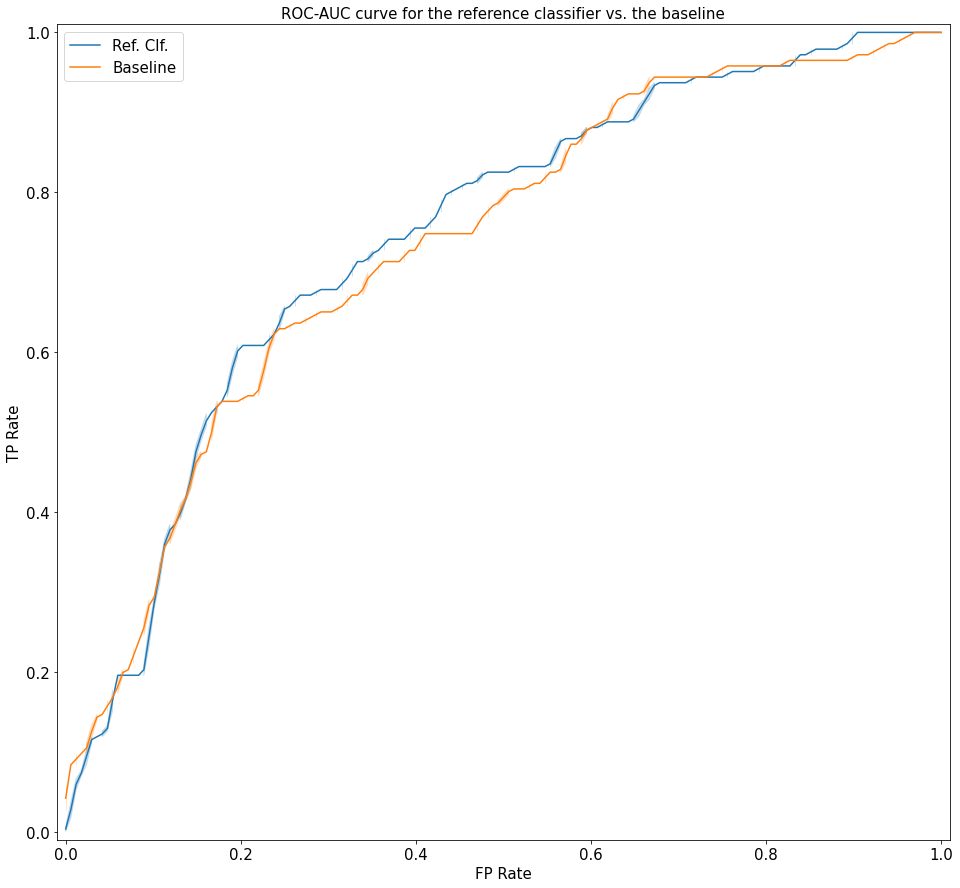

In [111]:
plt.figure(figsize=(16,15))
sns.lineplot(x='FP Rate', y='TP Rate', hue='Classifier', 
                             data=pd.DataFrame({'FP Rate': roc_our_clf[0] + [] + roc_baseline[0],
                                                'TP Rate': roc_our_clf[1] + [] + roc_baseline[1],
                                                'Classifier': ['Ref. Clf.']*len(roc_our_clf[0]) + 
                                                              ['Baseline']*len(roc_baseline[0])}))
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
fs = 15
plt.xlabel('FP Rate',fontsize=fs)
plt.ylabel('TP Rate',fontsize=fs)
plt.title('ROC-AUC curve for the reference classifier vs. the baseline', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)

In [264]:
roc_our_clf[1][280], roc_baseline[1][280]

(0.8313253012048193, 0.8313253012048193)

In [265]:
roc_our_clf[0][280], roc_baseline[0][280]

(0.23240589198036007, 0.23240589198036007)

In [266]:
def find_equality(a,b):
    for i in range(len(a[0])):
        if a[0][i] == b[0][i] and a[1][i] == b[1][i]:
            print(i)

In [267]:
find_equality(roc_our_clf, roc_baseline)

0
1
2
3
4
22
23
24
25
51
60
61
79
80
81
87
88
90
91
92
93
94
95
96
98
99
100
102
103
104
105
226
228
229
230
231
233
234
235
236
249
275
276
277
278
279
280
281
282
304
305
306
307
308
309
310
311
312
313
314
332
333
334
373
374
375
376
377
378
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777


In [122]:
merged_temp.sort_values('score_old', ascending=False).tail(merged_temp.shape[0]-311).head(50)

,row_class,Skills,aux_row_class,common_key,common_index,cont_pred,pred,indicator,score_diff,score_old
328,0,m2m technology,0,m2m technology_2018-2019,986,4.705461,0,1,0.0,9.0
327,0,codeigniter,0,codeigniter_2018-2019,347,2.113559,0,1,-4.0,9.0
326,0,dynatrace,0,dynatrace_2018-2019,567,5.084633,0,1,-5.0,9.0
325,1,user data analytics,1,user data analytics_2018-2019,1700,19.671955,1,1,27.0,9.0
324,1,data recovery,1,data recovery_2018-2019,472,7.885864,0,1,21.0,9.0
323,0,decision forest analysis,0,decision forest analysis_2018-2019,503,9.543657,0,1,-4.0,9.0
322,0,gnu compiler collection,0,gnu compiler collection_2018-2019,733,6.075176,0,1,-2.0,9.0
320,1,kotlin,1,kotlin_2018-2019,944,18.795507,1,1,30.0,9.0
321,0,mvvm,0,mvvm_2018-2019,1143,0.165162,0,1,8.0,9.0
318,0,industrial automation,0,industrial automation_2018-2019,826,0.201955,0,1,5.0,9.0


In [127]:
our_fn_their_tp = merged_temp.sort_values('score_old', ascending=False).head(311)
our_fn_their_tp = our_fn_their_tp.loc[(our_fn_their_tp.pred == 0) & (our_fn_their_tp.row_class == 1)]

our_tp_their_fn = merged_temp.sort_values('score_old', ascending=False).tail(merged_temp.shape[0] - 311)
our_tp_their_fn = our_tp_their_fn.loc[(our_tp_their_fn.pred == 1) & (our_tp_their_fn.row_class == 1)]

our_fn_their_fn = merged_temp.sort_values('score_old', ascending=False).tail(merged_temp.shape[0] - 311)
our_fn_their_fn = our_fn_their_fn.loc[(our_fn_their_fn.pred == 0) & (our_fn_their_fn.row_class == 1)]

our_fp_their_fp = merged_temp.sort_values('score_old', ascending=False).head(311)
our_fp_their_fp = our_fp_their_fp.loc[(our_fp_their_fp.pred == 1) & (our_fp_their_fp.row_class == 0)]

In [124]:
our_fn_their_tp

,row_class,Skills,aux_row_class,common_key,common_index,cont_pred,pred,indicator,score_diff,score_old
154,1,video analytics,1,video analytics_2018-2019,1730,11.174447,0,1,25.0,24.0
160,1,managed security services (mss),1,managed security services (mss)_2018-2019,1004,12.716117,0,1,117.0,23.0
165,1,tfs,1,tfs_2018-2019,1657,12.353232,0,1,25.0,22.0
173,1,microsoft dynamics nav,1,microsoft dynamics nav_2018-2019,1065,11.638815,0,1,31.0,21.0
181,1,xsl,1,xsl_2018-2019,1831,8.808774,0,1,20.0,20.0
196,1,appdynamics,1,appdynamics_2018-2019,160,8.404945,0,1,20.0,19.0
195,1,global positioning system,1,global positioning system_2018-2019,729,10.412391,0,1,24.0,19.0
187,1,a/b testing,1,a/b testing_2018-2019,7,8.268157,0,1,20.0,19.0
214,1,building management system,1,building management system_2018-2019,284,6.559658,0,1,24.0,17.0
223,1,keras,1,keras_2018-2019,929,10.599940,0,1,34.0,16.0


In [125]:
our_tp_their_fn

,row_class,Skills,aux_row_class,common_key,common_index,cont_pred,pred,indicator,score_diff,score_old
325,1,user data analytics,1,user data analytics_2018-2019,1700,19.671955,1,1,27.0,9.0
320,1,kotlin,1,kotlin_2018-2019,944,18.795507,1,1,30.0,9.0
350,1,bitbucket,1,bitbucket_2018-2019,263,16.564040,1,1,50.0,8.0
352,1,amazon redshift,1,amazon redshift_2018-2019,72,17.855422,1,1,39.0,8.0
335,1,knowledge graph,1,knowledge graph_2018-2019,937,28.132612,1,1,43.0,8.0
363,1,microsoft exchange system center (sccm/scom),1,microsoft exchange system center (sccm/scom)_2...,1067,12.722160,1,1,20.0,7.0
389,1,information extraction,1,information extraction_2018-2019,830,26.189360,1,1,64.0,6.0
491,1,cisco asa,1,cisco asa_2018-2019,316,14.063330,1,1,26.0,3.0


In [126]:
our_fn_their_fn

,row_class,Skills,aux_row_class,common_key,common_index,cont_pred,pred,indicator,score_diff,score_old
324,1,data recovery,1,data recovery_2018-2019,472,7.885864,0,1,21.0,9.0
314,1,"oracle 10g, 11g, 12c",1,"oracle 10g, 11g, 12c_2018-2019",1232,1.827557,0,1,30.0,9.0
355,1,tcl (programming language),1,tcl (programming language)_2018-2019,1637,10.245116,0,1,30.0,8.0
356,1,maintainability,1,maintainability_2018-2019,1002,7.903800,0,1,36.0,8.0
361,1,xhtml,1,xhtml_2018-2019,1825,4.443338,0,1,23.0,7.0
396,1,information retrieval,1,information retrieval_2018-2019,832,10.851098,0,1,24.0,6.0
384,1,myob,1,myob_2018-2019,1147,9.151987,0,1,26.0,6.0
437,1,rule engine,1,rule engine_2018-2019,1412,10.756523,0,1,23.0,5.0
462,1,cyber security compliance,1,cyber security compliance_2018-2019,430,9.076725,0,1,28.0,4.0
445,1,bluecoat,1,bluecoat_2018-2019,267,-0.019712,0,1,26.0,4.0


In [129]:
our_fp_their_fp.head(50)

,row_class,Skills,aux_row_class,common_key,common_index,cont_pred,pred,indicator,score_diff,score_old
12,0,outsystems,0,outsystems_2018-2019,1260,37.815203,1,1,-8.0,61.0
13,0,gaap,0,gaap_2018-2019,695,121.805774,1,1,1.0,60.0
16,0,predictive modelling,0,predictive modelling_2018-2019,1317,164.773653,1,1,19.0,59.0
19,0,ospf,0,ospf_2018-2019,1258,82.824741,1,1,18.0,58.0
21,0,wcf (windows communication foundation),0,wcf (windows communication foundation)_2018-2019,1761,152.150045,1,1,17.0,57.0
25,0,wpf (windows presentation foundation),0,wpf (windows presentation foundation)_2018-2019,1809,92.445310,1,1,-18.0,55.0
27,0,data center operations,0,data center operations_2018-2019,453,87.309882,1,1,13.0,54.0
28,0,java message service,0,java message service_2018-2019,888,72.729087,1,1,9.0,54.0
31,0,implementation plans,0,implementation plans_2018-2019,824,107.318561,1,1,-12.0,52.0
33,0,cryptocurrency,0,cryptocurrency_2018-2019,417,84.025300,1,1,-24.0,51.0


In [87]:
combined_df = pd.concat([tp_df[['Skills', 'score_diff', 'score_old']].assign(Group='True Positive'),
                         fp_df[['Skills', 'score_diff', 'score_old']].assign(Group='False Positive'),
                         fn_df[['Skills', 'score_diff', 'score_old']].assign(Group='False Negative')])

In [88]:
kruskal(tp_df.score_old.values, fn_df.score_old.values)

KruskalResult(statistic=52.947826088970544, pvalue=3.4252691555834445e-13)

In [89]:
kruskal(tp_df.score_old.values, fp_df.score_old.values)

KruskalResult(statistic=25.888459531610646, pvalue=3.61725261535176e-07)

In [90]:
kruskal(tp_df.score_diff.values, fn_df.score_diff.values)

KruskalResult(statistic=12.086097687531248, pvalue=0.0005079918484812004)

In [91]:
kruskal(tp_df.score_diff.values, fp_df.score_diff.values)

KruskalResult(statistic=180.2027748230548, pvalue=4.37669700561968e-41)

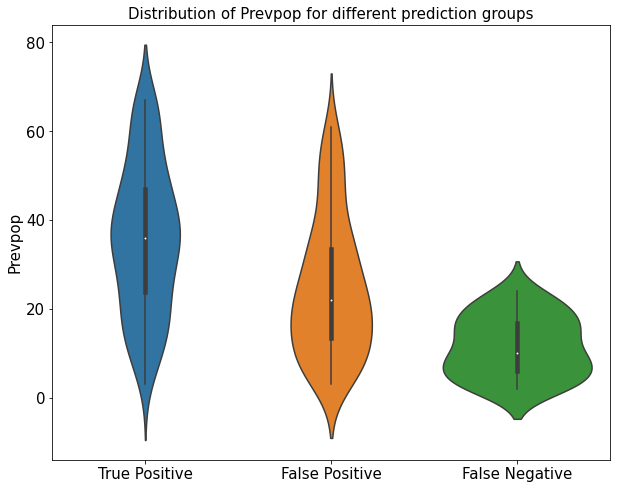

In [92]:
fig,ax=plt.subplots(1,1, figsize=(10,8))
sns.violinplot(x='Group', y='score_old', data=combined_df, ax=ax)
plt.xlabel('')
plt.ylabel('Prevpop', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Distribution of Prevpop for different prediction groups', fontsize=15)
plt.show()

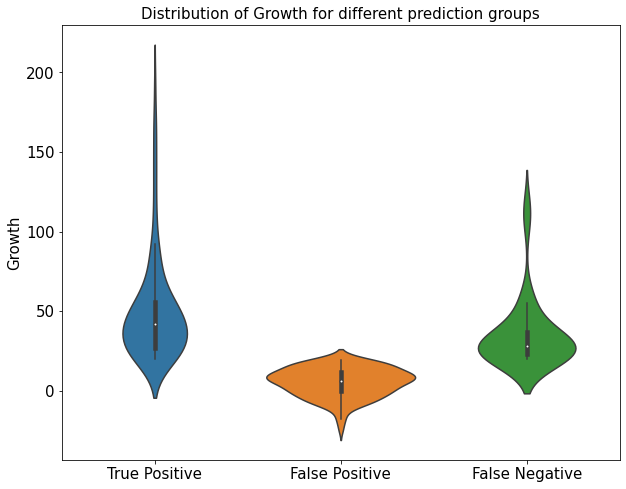

In [93]:
fig,ax=plt.subplots(1,1, figsize=(10,8))
sns.violinplot(x='Group', y='score_diff', data=combined_df, ax=ax)
plt.xlabel('')
plt.ylabel('Growth', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Distribution of Growth for different prediction groups', fontsize=15)
plt.show()

In [94]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(fp_df.sort_values('score_diff', ascending=False))

,common_key,row_class,Skills,pred,cont_pred,indicator,score_diff,score_old
4,predictive modelling_2018-2019,0,predictive modelling,1,164.773653,1,19.0,59.0
150,crystal reports_2018-2019,0,crystal reports,1,24.295677,1,19.0,17.0
237,mailchimp_2018-2019,0,mailchimp,1,12.979134,1,19.0,5.0
121,java persistence api (jpa)_2018-2019,0,java persistence api (jpa),1,31.525322,1,19.0,27.0
228,npm_2018-2019,0,npm,1,13.944804,1,18.0,22.0
235,hardware development_2018-2019,0,hardware development,1,13.152317,1,18.0,7.0
165,field-programmable gate array (integrated circuit)_2018-2019,0,field-programmable gate array (integrated circuit),1,21.362313,1,18.0,24.0
63,spss_2018-2019,0,spss,1,63.893894,1,18.0,38.0
52,ospf_2018-2019,0,ospf,1,82.824741,1,18.0,58.0
185,enterprise javabeans_2018-2019,0,enterprise javabeans,1,18.693024,1,17.0,14.0


In [95]:
fp_df[['score_old', 'score_diff']].describe()

,score_old,score_diff
count,111.000000,111.000000
mean,24.774775,5.342342
std,15.430009,9.061904
min,3.000000,-24.000000
25%,13.500000,-0.500000
50%,22.000000,6.000000
75%,33.500000,12.000000
max,61.000000,19.000000


In [96]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(fn_df.sort_values('score_diff', ascending=False))

,common_key,row_class,Skills,pred,cont_pred,indicator,score_diff,score_old
244,managed security services (mss)_2018-2019,1,managed security services (mss),0,12.716117,1,117.0,23.0
405,personal data protection act_2018-2019,1,personal data protection act,0,6.870982,1,106.0,14.0
328,as400 system_2018-2019,1,as400 system,0,8.901674,1,61.0,2.0
535,server administration_2018-2019,1,server administration,0,3.871731,1,55.0,15.0
457,video editing_2018-2019,1,video editing,0,5.756818,1,52.0,12.0
411,teradata_2018-2019,1,teradata,0,6.653943,1,46.0,15.0
531,cobol_2018-2019,1,cobol,0,3.971696,1,40.0,2.0
367,online analytical processing (olap)_2018-2019,1,online analytical processing (olap),0,7.996918,1,38.0,3.0
582,unix shell_2018-2019,1,unix shell,0,2.454763,1,37.0,15.0
371,maintainability_2018-2019,1,maintainability,0,7.903800,1,36.0,8.0


In [97]:
fn_df[['score_old', 'score_diff']].describe()

,score_old,score_diff
count,34.000000,34.000000
mean,11.588235,35.117647
std,6.809608,21.966593
min,2.000000,20.000000
25%,6.000000,23.250000
50%,10.000000,28.000000
75%,16.750000,36.750000
max,24.000000,117.000000


In [98]:
monthly_skill_data.loc[monthly_skill_data.TagName == 'keras']

,TagName,Date,Count
8637,keras,2018-02-01,1
8638,keras,2018-03-01,1
8639,keras,2018-04-01,1
8640,keras,2018-05-01,2
8641,keras,2018-06-01,1
8642,keras,2018-07-01,2
8643,keras,2018-08-01,4
8644,keras,2018-11-01,4
8645,keras,2019-02-01,2
8646,keras,2019-03-01,3


In [99]:
sorted_cont_preds.loc[sorted_cont_preds.Skills.apply(lambda x: x in fn_df.Skills.values)]

,common_key,row_class,Skills,pred,cont_pred,indicator
244,managed security services (mss)_2018-2019,1,managed security services (mss),0,12.716117,1
248,tfs_2018-2019,1,tfs,0,12.353232,1
256,microsoft dynamics nav_2018-2019,1,microsoft dynamics nav,0,11.638815,1
263,video analytics_2018-2019,1,video analytics,0,11.174447,1
268,adobe premiere pro_2018-2019,1,adobe premiere pro,0,11.100256,1
274,information retrieval_2018-2019,1,information retrieval,0,10.851098,1
282,rule engine_2018-2019,1,rule engine,0,10.756523,1
286,keras_2018-2019,1,keras,0,10.599940,1
289,global positioning system_2018-2019,1,global positioning system,0,10.412391,1
292,less (stylesheet language)_2018-2019,1,less (stylesheet language),0,10.365202,1


In [100]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(tp_df.sort_values('score_diff', ascending=False))

,common_key,row_class,Skills,pred,cont_pred,indicator,score_diff,score_old
17,kubernetes_2018-2019,1,kubernetes,1,122.632824,1,193.0,52.0
33,social media (youtube)_2018-2019,1,social media (youtube),1,101.039662,1,169.0,67.0
21,infrastructure-as-a-service (iaas)_2018-2019,1,infrastructure-as-a-service (iaas),1,118.350097,1,168.0,62.0
27,google ads_2018-2019,1,google ads,1,110.497483,1,153.0,40.0
104,pl/sql_2018-2019,1,pl/sql,1,36.338249,1,147.0,30.0
19,application security design_2018-2019,1,application security design,1,120.108770,1,134.0,67.0
10,soap_2018-2019,1,soap,1,141.146746,1,131.0,66.0
22,microsoft office 365_2018-2019,1,microsoft office 365,1,117.906842,1,114.0,57.0
118,network theorems_2018-2019,1,network theorems,1,32.964137,1,112.0,22.0
12,natural language processing (nlp)_2018-2019,1,natural language processing (nlp),1,137.982667,1,103.0,57.0


In [101]:
tp_df[['score_old', 'score_diff']].describe()

,score_old,score_diff
count,132.000000,132.000000
mean,35.689394,49.893939
std,16.599518,32.499503
min,3.000000,20.000000
25%,23.750000,27.000000
50%,36.000000,42.000000
75%,47.000000,55.750000
max,67.000000,193.000000


In [78]:
first_half_skills = set(af_icf_top_periods.loc[(af_icf_top_periods.year=='2019')
                                            &(af_icf_top_periods.period=='0')].TagName.values)
second_half_skills = set(af_icf_top_periods.loc[(af_icf_top_periods.year=='2019')
                                            &(af_icf_top_periods.period=='1')].TagName.values)

In [79]:
tp_df.loc[tp_df.Skills.apply(lambda x: 
                 x in second_half_skills)]

,common_key,row_class,Skills,pred,cont_pred,indicator,score_diff,score_old
0,wireframes_2018-2019,1,wireframes,1,204.149159,1,60.0,67.0
1,business intelligence (bi) tools_2018-2019,1,business intelligence (bi) tools,1,190.750547,1,59.0,44.0
3,internet information services_2018-2019,1,internet information services,1,168.887550,1,69.0,65.0
7,google analytics_2018-2019,1,google analytics,1,151.026940,1,38.0,66.0
10,soap_2018-2019,1,soap,1,141.146746,1,131.0,66.0
...,...,...,...,...,...,...,...,...
210,biotechnology_2018-2019,1,biotechnology,1,15.995261,1,42.0,17.0
227,cisco asa_2018-2019,1,cisco asa,1,14.063330,1,26.0,3.0
231,pytorch_2018-2019,1,pytorch,1,13.736316,1,21.0,19.0
234,e-mail marketing_2018-2019,1,e-mail marketing,1,13.383098,1,49.0,25.0


In [80]:
len(second_half_skills), len(first_half_skills)

(148, 157)

In [81]:
tp_df.loc[tp_df.Skills.apply(lambda x: 
                 x in first_half_skills)]

,common_key,row_class,Skills,pred,cont_pred,indicator,score_diff,score_old
0,wireframes_2018-2019,1,wireframes,1,204.149159,1,60.0,67.0
1,business intelligence (bi) tools_2018-2019,1,business intelligence (bi) tools,1,190.750547,1,59.0,44.0
2,ajax_2018-2019,1,ajax,1,174.488971,1,42.0,60.0
5,it service management_2018-2019,1,it service management,1,154.965617,1,35.0,56.0
7,google analytics_2018-2019,1,google analytics,1,151.026940,1,38.0,66.0
...,...,...,...,...,...,...,...,...
210,biotechnology_2018-2019,1,biotechnology,1,15.995261,1,42.0,17.0
214,informatica_2018-2019,1,informatica,1,15.734588,1,33.0,23.0
224,microsoft ssis_2018-2019,1,microsoft ssis,1,14.322246,1,21.0,10.0
234,e-mail marketing_2018-2019,1,e-mail marketing,1,13.383098,1,49.0,25.0


In [82]:
tp_df.loc[tp_df.Skills.apply(lambda x: 
                 x in first_half_skills.difference(second_half_skills))].shape[0], \
                    len(second_final_diffs['2019'].intersection(first_half_skills.difference(second_half_skills)))

(38, 47)

In [87]:
baseline_tp_df.loc[baseline_tp_df.Skills.apply(lambda x: 
                 x in first_half_skills.difference(second_half_skills))].shape[0], \
                    len(second_final_diffs['2019'].intersection(first_half_skills.difference(second_half_skills)))

(37, 47)

In [83]:
tp_df.loc[tp_df.Skills.apply(lambda x: 
                 x in second_half_skills.difference(first_half_skills))].shape[0], \
                    len(second_final_diffs['2019'].intersection(second_half_skills.difference(first_half_skills)))

(23, 39)

In [86]:
baseline_tp_df.loc[baseline_tp_df.Skills.apply(lambda x: 
                 x in second_half_skills.difference(first_half_skills))].shape[0], \
                len(second_final_diffs['2019'].intersection(second_half_skills.difference(first_half_skills)))

(31, 39)

In [290]:
len(second_half_skills.intersection(first_half_skills).intersection(second_final_diffs['2019']))

71

In [291]:
from scipy.stats import chisquare
chisquare([38,9], [92,27])

Power_divergenceResult(statistic=43.69565217391305, pvalue=3.83623093595911e-11)

### Correlations between features in different years

In [766]:
train_x = df_x_datapoints_with_ground_truth.loc[
            df_x_datapoints_with_ground_truth.common_key.apply(lambda x: x.split('_')[1] == '2017-2018')]
test_x = df_x_datapoints_with_ground_truth.loc[
            df_x_datapoints_with_ground_truth.common_key.apply(lambda x: x.split('_')[1] == '2018-2019')]
shared_skills = pd.merge(train_x, test_x, on='Skill', suffixes=('_train', '_test'))
train_x = series_to_matrix(shared_skills[feature_type_to_use+'_train'])
test_x = series_to_matrix(shared_skills[feature_type_to_use+'_test'])

In [767]:
from scipy.stats import pearsonr

{tsfresh_feature_names[i]:
     pearsonr(train_x[:, i].flatten(), test_x[:, i].flatten()) for i in range(train_x.shape[1])}

/Users/ramtinyazdanian/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'variance_larger_than_standard_deviation': (0.5520834290709346,
  1.0565247061602503e-51),
 'has_duplicate_max': (0.11513922354471556, 0.00374988231045713),
 'has_duplicate_min': (0.275043233018716, 1.964858601809825e-12),
 'has_duplicate': (0.12014759193262474, 0.0024826314321698827),
 'sum_values': (0.9299524823155755, 6.017686749842841e-276),
 'abs_energy': (0.8934636269251057, 3.53697940878192e-221),
 'mean_abs_change': (0.8733108463438876, 6.247971148641775e-199),
 'mean_change': (0.3883731671454859, 3.48157309985864e-24),
 'mean_second_derivative_central': (0.5564900860025638,
  1.1370357937689602e-52),
 'median': (0.9265146989410611, 1.234711127681832e-269),
 'mean': (0.9299524823155755, 6.017686749842841e-276),
 'standard_deviation': (0.7876315507629438, 1.2772531837740096e-134),
 'variation_coefficient': (0.4745653693292815, 8.241882264345538e-37),
 'variance': (0.6959904493242904, 1.087963083829901e-92),
 'skewness': (0.09731730414006114, 0.014385610556813432),
 'kurtosis': 

In [95]:
pd.DataFrame(test_x.tolist(), columns=None).corr()

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,1.000000,-0.080804,-0.073643,-0.226075,0.637145,0.356311,0.664163,0.568629,0.659782,0.632770,...,-0.292593,0.177134,0.699689,-0.708448,-0.033304,0.093612,0.262072,0.176034,0.236652,0.091501
1,-0.080804,1.000000,0.167933,0.357422,-0.062650,-0.028823,-0.067596,-0.046170,-0.065278,-0.061890,...,-0.162201,-0.029976,-0.097481,0.096366,0.012530,-0.051041,-0.123265,-0.234389,-0.314841,0.062553
2,-0.073643,0.167933,1.000000,0.325746,-0.053121,-0.026211,-0.060090,-0.034696,-0.045325,-0.054117,...,-0.138548,0.024966,-0.084182,0.083149,0.064427,0.020771,-0.112341,-0.213617,-0.286939,0.080618
3,-0.226075,0.357422,0.325746,1.000000,-0.184039,-0.080011,-0.188363,-0.137175,-0.185326,-0.184736,...,0.011189,0.230385,-0.289966,0.302482,0.127203,0.033898,-0.344871,-0.655776,-0.880866,0.237008
4,0.637145,-0.062650,-0.053121,-0.184039,1.000000,0.886885,0.970249,0.846159,0.953156,0.999119,...,-0.267745,0.136936,0.572408,-0.577220,0.016650,0.050610,0.237434,0.105366,0.179647,0.127955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.093612,-0.051041,0.020771,0.033898,0.050610,0.033918,0.044791,0.059212,0.038524,0.046865,...,0.047855,-0.131431,0.042599,-0.041041,0.322388,1.000000,0.183177,0.156299,0.146179,-0.102478
195,0.262072,-0.123265,-0.112341,-0.344871,0.237434,0.147132,0.231674,0.245668,0.225529,0.234670,...,0.007787,-0.249921,0.193535,-0.198315,0.013576,0.183177,1.000000,0.518645,0.408709,-0.118597
196,0.176034,-0.234389,-0.213617,-0.655776,0.105366,0.052581,0.111244,0.082497,0.100722,0.104466,...,0.106713,-0.207913,0.129948,-0.142129,-0.047406,0.156299,0.518645,1.000000,0.744468,-0.231835
197,0.236652,-0.314841,-0.286939,-0.880866,0.179647,0.081310,0.176559,0.139709,0.167035,0.179499,...,0.036431,-0.245344,0.284395,-0.297375,-0.063114,0.146179,0.408709,0.744468,1.000000,-0.261787
